<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 4 Lesson 3*

# Generative Adversarial Networks (GANs)


*PS: The person below does not exist*


<img src="https://thispersondoesnotexist.com/image" width=500>

# Lecture

Learning Objectives:
1. What is a GAN?
    - Describe the mechanisms of a Generator & Discriminator
    - Describe the Adverserial process
2. How does a GAN achieve good results?
    - Talk about relationship with Game Theory 
    - Illustrate NASH equilibrium

## GAN Overview
<img  src="GAN Overview.jpeg" width=800>

<br></br>
<br></br>
<br></br>

## GAN Framework
<img  src="GAN Framework.jpeg" width=800>

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [ ]:
!pip install tqdm

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [ ]:
np.random.seed(10)
random_dim = 100
 
def load_minst_data():
    # load the data - we'll use Fashion MNIST, for a change of pace
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [ ]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
train(40, 64)

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [ ]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

In [ ]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()

In [ ]:
from IPython.display import Image
Image(filename='results/example.png')

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [ ]:
!pip install emoji_data_python

In [ ]:
#!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

In [4]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [5]:
example_emoji.shape

(28, 28, 4)

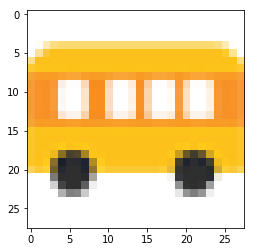

In [6]:
plt.imshow(example_emoji);

In [7]:
grayscale_emoji.shape

(28, 28)

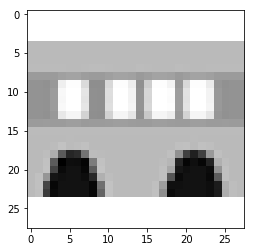

In [8]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [20]:
## load and process data to turn to grayscale and right shape for the network
from zipfile import ZipFile

np.random.seed(10)
random_dim = 100

# Create a ZipFile Object and load emoji.zip in it
with ZipFile('emoji.zip', 'r') as zipObj:
   # Get list of files names in zip
   listOemojis = zipObj.namelist()


In [32]:
emoji_test = []

for emoji in listOemojis:
    og_emoji = imageio.imread(emoji)
    grayscale_emoji = color.rgb2gray(og_emoji)
    emoji_test.append(grayscale_emoji)

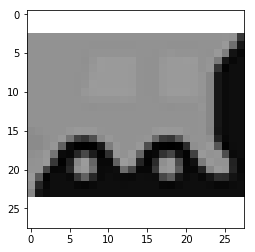

In [48]:
emoji_test = np.array(emoji_test)

In [49]:
emoji_test.shape

(861, 28, 28)

In [50]:
np.random.seed(10)
random_dim = 100
 
def transform_emojis():
    emoji_train = (emoji_test.astype(np.float32) - 127.5)/127.5
    # convert emoji_train with a shape of (861, 28, 28) to (861, 784) so we have
    # 784 columns per row
    emoji_train = emoji_train.reshape(861, 784)
    return emoji_train

In [51]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.2)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # initially set trainable to False since we only want to train either the 
    # generator or the discriminator at a time
    discriminator.trainable = False
    #gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (prob if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10,10),
                         figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_emoji_epoch_%d.png' % epoch)

  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.00it/s]

--------------- Epoch 2 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.93it/s]

--------------- Epoch 3 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 4 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 5 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 6 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 7 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 8 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 9 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 10 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 11 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 12 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 13 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 14 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 15 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 16 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 17 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 18 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 19 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 20 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 21 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 22 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 23 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 24 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 25 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 26 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 27 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 28 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 29 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 30 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 31 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 32 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 33 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 34 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 35 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 36 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 37 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 38 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 39 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 40 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 41 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.35it/s]

--------------- Epoch 42 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 43 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 44 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 45 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 46 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 47 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.73it/s]

--------------- Epoch 48 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 49 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 50 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 51 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 52 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 53 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 54 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 55 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 56 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 57 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 58 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 59 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 60 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 61 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 62 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 63 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.35it/s]

--------------- Epoch 64 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 65 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 66 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 67 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 68 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 69 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 70 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 71 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 72 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 73 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 74 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 75 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 76 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 77 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 78 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 79 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 80 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 81 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 82 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 83 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 84 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 85 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 86 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.42it/s]

--------------- Epoch 87 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 88 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 89 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 90 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 91 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 92 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 93 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 94 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 95 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 96 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.48it/s]

--------------- Epoch 97 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 98 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 99 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 100 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 101 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 102 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 103 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 104 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 105 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 106 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 107 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.09it/s]

--------------- Epoch 108 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.19it/s]

--------------- Epoch 109 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 110 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.78it/s]

--------------- Epoch 111 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.51it/s]

--------------- Epoch 112 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 113 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.90it/s]

--------------- Epoch 114 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 115 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 116 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.97it/s]

--------------- Epoch 117 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 118 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 119 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 120 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 121 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.27it/s]

--------------- Epoch 122 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 123 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.44it/s]

--------------- Epoch 124 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 125 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 126 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.06it/s]

--------------- Epoch 127 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.79it/s]

--------------- Epoch 128 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.23it/s]

--------------- Epoch 129 ---------------



 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 130 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 131 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.69it/s]

--------------- Epoch 132 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.23it/s]

--------------- Epoch 133 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 134 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.93it/s]

--------------- Epoch 135 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.28it/s]

--------------- Epoch 136 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 137 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 138 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 139 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 140 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 141 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 142 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 143 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 144 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 145 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 146 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 147 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.78it/s]

--------------- Epoch 148 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 149 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 150 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 151 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 152 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 153 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 154 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 155 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 156 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 157 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 158 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 159 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 160 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 161 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 162 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 163 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 164 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.59it/s]

--------------- Epoch 165 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 166 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 167 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 168 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 169 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 170 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 171 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 172 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 173 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 174 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.13it/s]

--------------- Epoch 175 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 176 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 177 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 178 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.71it/s]

--------------- Epoch 179 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.11it/s]

--------------- Epoch 180 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 181 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 182 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 183 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 184 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 185 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 186 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 187 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.05it/s]

--------------- Epoch 188 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 189 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 190 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 191 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 192 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 193 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 194 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 195 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 196 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.68it/s]

--------------- Epoch 197 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 198 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 199 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 200 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 201 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 202 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 203 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 204 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 205 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 206 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 207 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 208 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 209 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 210 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 211 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 212 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 213 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 214 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 215 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 216 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 217 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 218 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 219 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 220 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 221 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.52it/s]

--------------- Epoch 222 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 223 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 224 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 225 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 226 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 227 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 228 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 229 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 230 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 231 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 232 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 233 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 234 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 235 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 236 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 237 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 238 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.93it/s]

--------------- Epoch 239 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 240 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 241 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 242 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 243 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 244 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 245 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 246 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 247 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 248 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 249 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 250 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.50it/s]

--------------- Epoch 251 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 252 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.78it/s]

--------------- Epoch 253 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 254 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 255 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 256 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 257 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 258 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 259 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 260 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 261 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 262 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 263 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.16it/s]

--------------- Epoch 264 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 265 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 266 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 267 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 268 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 269 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 270 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 271 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 272 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 273 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 274 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 275 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 276 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 277 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 278 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 279 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 280 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 281 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 282 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 283 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 284 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 285 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 286 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 287 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 288 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 289 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 290 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 291 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 292 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.39it/s]

--------------- Epoch 293 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 294 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 295 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 296 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 297 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 298 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 299 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.08it/s]

--------------- Epoch 301 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 302 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 303 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 304 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 305 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 306 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 307 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 308 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 309 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 310 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 311 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 312 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 313 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 314 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 315 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.11it/s]

--------------- Epoch 316 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 317 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 318 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 320 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 321 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 322 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 323 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 324 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 325 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 326 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 327 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 328 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 329 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.86it/s]

--------------- Epoch 330 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 331 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.79it/s]

--------------- Epoch 332 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 333 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.67it/s]

--------------- Epoch 334 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 335 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 336 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 337 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 338 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 339 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.59it/s]

--------------- Epoch 340 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 341 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 342 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.16it/s]

--------------- Epoch 343 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 344 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.90it/s]

--------------- Epoch 345 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 346 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.58it/s]

--------------- Epoch 347 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 348 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 349 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 350 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 351 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 352 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 353 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 354 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 355 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 356 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 357 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 358 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 359 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 360 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 361 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 362 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 363 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 364 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 365 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 366 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 367 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 368 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.95it/s]

--------------- Epoch 369 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 370 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 371 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 372 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 373 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.26it/s]

--------------- Epoch 374 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.89it/s]

--------------- Epoch 375 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 376 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 377 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 378 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 379 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.66it/s]

--------------- Epoch 380 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 381 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 382 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 383 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 384 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 385 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 386 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.98it/s]

--------------- Epoch 387 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 388 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 389 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 390 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 391 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 392 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 393 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 394 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 395 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 396 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 397 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 398 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 399 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 400 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 401 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.97it/s]

--------------- Epoch 402 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.94it/s]

--------------- Epoch 403 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 404 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 405 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 406 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 407 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 409 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 410 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 411 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 412 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 413 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 414 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 415 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 416 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 417 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.10it/s]

--------------- Epoch 418 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 419 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 420 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 421 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 422 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 423 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 424 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 425 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 426 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 427 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 428 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 429 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 430 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 431 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 432 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 433 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 434 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 435 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 436 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 437 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 438 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 439 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 440 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 441 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 442 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.89it/s]

--------------- Epoch 443 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 444 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 445 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 446 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 447 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 448 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 449 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 450 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 451 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 452 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 453 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.98it/s]

--------------- Epoch 454 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 455 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 456 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 457 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 458 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 459 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 460 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 461 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 462 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 463 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 464 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 465 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 466 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 467 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 468 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 469 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 470 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 471 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 472 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.79it/s]

--------------- Epoch 473 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 474 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 475 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 476 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 477 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 478 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 479 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 480 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 481 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 482 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.16it/s]

--------------- Epoch 483 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 484 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 485 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 486 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 487 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 488 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 489 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 490 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 491 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 492 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 493 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 494 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 495 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 496 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 497 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 498 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 499 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.90it/s]

--------------- Epoch 500 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 501 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 502 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 503 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 504 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 505 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 506 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 507 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.92it/s]

--------------- Epoch 508 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 509 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 510 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 511 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 512 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 513 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 514 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.13it/s]

--------------- Epoch 515 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 516 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 517 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 518 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 519 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 520 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 521 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.20it/s]

--------------- Epoch 522 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 523 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 524 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 525 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.43it/s]

--------------- Epoch 526 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 527 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 528 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 529 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 530 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 531 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 532 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 533 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.52it/s]

--------------- Epoch 534 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 535 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 536 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 537 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 538 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 539 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 540 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 541 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 542 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 543 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 544 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 545 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 546 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 547 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 548 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 549 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 550 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 551 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 552 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 553 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 554 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 555 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 556 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 557 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 558 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 559 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 560 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 561 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 562 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 563 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 564 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 565 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 566 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 567 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 568 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.94it/s]

--------------- Epoch 569 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 570 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 571 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 572 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 573 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.95it/s]

--------------- Epoch 574 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 575 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 576 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 577 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 578 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 579 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 580 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 581 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 582 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 583 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 584 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 585 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 586 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 587 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 588 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 589 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 590 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 591 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 592 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 593 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 594 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 595 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 596 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 597 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.17it/s]

--------------- Epoch 598 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 599 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 600 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 601 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 602 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 603 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 604 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 605 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 606 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 607 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 608 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 609 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 610 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 611 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 612 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 613 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 614 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.21it/s]

--------------- Epoch 615 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 616 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 617 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 618 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 619 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 620 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.57it/s]

--------------- Epoch 621 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 622 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 623 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 624 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 625 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.86it/s]

--------------- Epoch 626 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.29it/s]

--------------- Epoch 627 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.83it/s]

--------------- Epoch 628 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.11it/s]

--------------- Epoch 629 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 630 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 631 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 632 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 633 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 634 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 635 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 636 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 637 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 638 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 639 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 640 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.99it/s]

--------------- Epoch 641 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 642 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 643 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.47it/s]

--------------- Epoch 644 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.19it/s]

--------------- Epoch 645 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.17it/s]

--------------- Epoch 646 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.30it/s]

--------------- Epoch 647 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.96it/s]

--------------- Epoch 648 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.05it/s]

--------------- Epoch 649 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 650 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.78it/s]

--------------- Epoch 651 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 652 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 653 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 654 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.67it/s]

--------------- Epoch 655 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 656 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 657 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 658 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 659 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.08it/s]

--------------- Epoch 660 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 661 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 662 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 663 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.89it/s]

--------------- Epoch 664 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 665 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 666 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 667 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 668 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 669 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 670 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 671 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 672 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 673 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 674 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 675 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 676 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 677 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 678 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 679 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 680 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 681 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 682 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 683 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 684 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 685 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 686 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 687 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 688 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 689 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.92it/s]

--------------- Epoch 690 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 691 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 692 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 693 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 694 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.11it/s]

--------------- Epoch 695 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 696 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 697 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 698 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 699 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 700 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 701 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 702 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 703 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.40it/s]

--------------- Epoch 704 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.71it/s]

--------------- Epoch 705 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 706 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 707 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 708 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 709 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 710 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 711 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 712 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.90it/s]

--------------- Epoch 713 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 714 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 715 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 716 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 717 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 718 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 719 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 720 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 721 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 722 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 723 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 724 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 725 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 726 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.68it/s]

--------------- Epoch 727 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 728 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 729 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 730 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.59it/s]

--------------- Epoch 731 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 732 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 733 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 734 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 735 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 736 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.73it/s]

--------------- Epoch 737 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.05it/s]

--------------- Epoch 738 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 739 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 740 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 741 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 742 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 743 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 744 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 745 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 746 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 747 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 748 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.22it/s]

--------------- Epoch 749 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 750 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 751 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 752 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.78it/s]

--------------- Epoch 753 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.19it/s]

--------------- Epoch 754 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 755 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 756 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 757 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.86it/s]

--------------- Epoch 758 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 759 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.50it/s]

--------------- Epoch 760 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.90it/s]

--------------- Epoch 761 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 762 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 763 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 764 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 765 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.15it/s]

--------------- Epoch 766 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 767 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 768 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 769 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 770 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 771 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.92it/s]

--------------- Epoch 772 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 773 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 774 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 775 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 776 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.99it/s]

--------------- Epoch 777 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.50it/s]

--------------- Epoch 778 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 779 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 780 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.68it/s]

--------------- Epoch 781 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 782 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 783 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 784 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 785 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.76it/s]

--------------- Epoch 786 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 787 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 788 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 789 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 790 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 791 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 792 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 793 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 794 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 795 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 796 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.58it/s]

--------------- Epoch 797 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 798 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 799 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 800 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 801 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.94it/s]

--------------- Epoch 802 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 803 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 804 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 805 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 806 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 807 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 808 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.95it/s]

--------------- Epoch 809 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 810 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 811 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 812 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 813 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 814 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 815 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 816 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 817 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 818 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 819 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 820 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 821 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 822 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 823 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 824 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 825 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 826 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 827 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 828 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 829 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 830 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.92it/s]

--------------- Epoch 831 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 832 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 833 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 834 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 835 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 836 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 837 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 838 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 839 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 840 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 841 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 842 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.06it/s]

--------------- Epoch 843 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 844 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 845 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 846 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 847 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 848 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 849 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 850 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 851 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 852 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 853 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.68it/s]

--------------- Epoch 854 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 855 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 856 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 857 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 858 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 859 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 860 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 861 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 862 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 863 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 864 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 865 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 866 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 867 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 868 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 869 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 870 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 871 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 872 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 873 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 874 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 875 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 876 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.66it/s]

--------------- Epoch 877 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 878 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 879 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 880 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 881 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 882 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 883 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 884 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.59it/s]

--------------- Epoch 885 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 886 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 887 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 888 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 889 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 890 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 891 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 892 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 893 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 894 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 895 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.48it/s]

--------------- Epoch 896 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 897 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 898 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.35it/s]

--------------- Epoch 899 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.66it/s]

--------------- Epoch 900 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 901 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 902 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.90it/s]

--------------- Epoch 903 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 904 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 905 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 906 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 907 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 908 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 909 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 910 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 911 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 912 ---------------


100%|██████████| 13/13 [00:00<00:00, 64.89it/s]

--------------- Epoch 913 ---------------



 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 914 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 915 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 916 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 917 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 918 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 919 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 920 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 921 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 922 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 923 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 924 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 925 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 926 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 927 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 928 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 929 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.56it/s]

--------------- Epoch 930 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 931 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 932 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 933 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.58it/s]

--------------- Epoch 934 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 935 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 936 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 937 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 938 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 939 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.66it/s]

--------------- Epoch 940 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 941 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 942 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 943 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.75it/s]

--------------- Epoch 944 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 945 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 946 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.87it/s]

--------------- Epoch 947 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 948 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 949 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.95it/s]

--------------- Epoch 950 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 951 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 952 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 953 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 954 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 955 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.76it/s]

--------------- Epoch 956 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 957 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 958 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 959 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 960 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 961 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.25it/s]

--------------- Epoch 962 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 963 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 964 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 55.37it/s]

--------------- Epoch 965 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.82it/s]

--------------- Epoch 966 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.02it/s]

--------------- Epoch 967 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 968 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.93it/s]

--------------- Epoch 969 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.88it/s]

--------------- Epoch 970 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 971 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 972 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 973 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 974 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 975 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 976 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 977 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 978 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 979 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 980 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.02it/s]

--------------- Epoch 981 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 982 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 983 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 984 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 985 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 986 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 987 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 988 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 989 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 990 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 991 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 992 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 993 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 994 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 995 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 996 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 997 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.29it/s]

--------------- Epoch 998 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.50it/s]

--------------- Epoch 999 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 1000 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.14it/s]

--------------- Epoch 1001 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.51it/s]

--------------- Epoch 1002 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.71it/s]

--------------- Epoch 1003 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.68it/s]

--------------- Epoch 1004 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.59it/s]

--------------- Epoch 1005 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.04it/s]

--------------- Epoch 1006 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 1007 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 1008 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 1009 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 1010 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 60.00it/s]

--------------- Epoch 1011 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.42it/s]

--------------- Epoch 1012 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 1013 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 1014 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 1015 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 1016 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.70it/s]

--------------- Epoch 1017 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1018 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 1019 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 1020 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 1021 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.59it/s]

--------------- Epoch 1022 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 1023 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 1024 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 1025 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 1026 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 1027 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1028 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 1029 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 1030 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 1031 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1032 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1033 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 1034 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 1035 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 1036 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1037 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 1038 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.29it/s]

--------------- Epoch 1039 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1040 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 1041 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1042 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1043 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1044 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1045 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 1046 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 1047 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.08it/s]

--------------- Epoch 1048 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1049 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.67it/s]

--------------- Epoch 1050 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 1051 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 1052 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1053 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1054 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 1055 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 1056 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1057 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1058 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 1059 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 1060 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1061 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 1062 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1063 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 1064 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 1065 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 1066 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 1067 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.69it/s]

--------------- Epoch 1068 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 1069 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 1070 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.79it/s]

--------------- Epoch 1071 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 1072 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 1073 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 1074 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 1075 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 1076 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 1077 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 1078 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 1079 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 1080 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1081 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 1082 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 1083 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1084 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 1085 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 1086 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1087 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 1088 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.43it/s]

--------------- Epoch 1089 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 1090 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 1091 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1092 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1093 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1094 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 1095 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 1096 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1097 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1098 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1099 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 1100 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 1101 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 1102 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1103 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 1104 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 1105 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 1106 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.45it/s]

--------------- Epoch 1107 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 1108 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 1109 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 1110 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1111 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 1112 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 1113 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 1114 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 1115 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 1116 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 1117 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 1118 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 1119 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 1120 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 1121 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 1122 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 1123 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 1124 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 1125 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1126 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1127 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1128 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1129 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1130 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 1131 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1132 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1133 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1134 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1135 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 1136 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1137 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 1138 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 1139 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 1140 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 1141 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.11it/s]

--------------- Epoch 1142 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 1143 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 1144 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1145 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 1146 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 1147 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1148 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1149 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.50it/s]

--------------- Epoch 1150 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 1151 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 1152 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1153 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.48it/s]

--------------- Epoch 1154 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1155 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1156 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 1157 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 1158 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1159 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 1160 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 1161 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 1162 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1163 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1164 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1165 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 1166 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1167 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 1168 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 1169 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 1170 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 1171 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1172 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1173 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 1174 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1175 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1176 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 1177 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1178 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1179 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 1180 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1181 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 1182 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1183 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 1184 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1185 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1186 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1187 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1188 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 1189 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 1190 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1191 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 1192 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1193 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1194 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1195 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 1196 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1197 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 1198 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 1199 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1200 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 1201 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 1202 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1203 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1204 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1205 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 1206 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1207 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 1208 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1209 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1210 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 1211 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 1212 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 1213 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1214 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1215 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1216 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 1217 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 1218 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1219 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1220 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 1221 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 1222 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1223 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1224 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 1225 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1226 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 1227 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1228 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1229 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1230 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1231 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 1232 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1233 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1234 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1235 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1236 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 1237 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 1238 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 1239 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 1240 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 1241 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 1242 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1243 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 1244 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1245 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 1246 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 1247 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1248 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1249 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 1250 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 1251 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 1252 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 1253 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1254 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 1255 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 1256 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1257 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1258 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 1259 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 1260 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 1261 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 1262 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1263 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.87it/s]

--------------- Epoch 1264 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1265 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1266 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 1267 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1268 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 1269 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 1270 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 1271 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1272 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1273 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1274 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1275 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 1276 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1277 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 1278 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 1279 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1280 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 1281 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 1282 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 1283 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1284 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1285 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 1286 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 1287 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 1288 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1289 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 1290 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 1291 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1292 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1293 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 1294 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1295 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 1296 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 1297 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 1298 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 1299 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 1301 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 1302 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 1303 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1304 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 1305 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1306 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 1307 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 1308 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1309 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1310 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 1311 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 1312 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 1313 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 1314 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1315 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1316 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 1317 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 1318 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 1319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 1320 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 1321 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1322 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1323 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 1324 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1325 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 1326 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1327 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 1328 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 1329 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 1330 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 1331 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1332 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 1333 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 1334 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 1335 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 1336 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 1337 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 1338 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1339 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 1340 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1341 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 1342 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1343 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1344 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1345 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 1346 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 1347 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 1348 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 1349 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 1350 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1351 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1352 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 1353 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1354 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1355 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 1356 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1357 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 1358 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 1359 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.11it/s]

--------------- Epoch 1360 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 1361 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1362 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 1363 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1364 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 1365 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1366 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 1367 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 1368 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1369 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 1370 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 1371 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 1372 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1373 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1374 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1375 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1376 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 1377 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 1378 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1379 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1380 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 1381 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 1382 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 1383 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1384 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 1385 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1386 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 1387 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 1388 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 1389 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 1390 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1391 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1392 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 1393 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1394 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 1395 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1396 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 1397 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1398 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1399 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1400 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1401 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1402 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 1403 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 1404 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1405 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1406 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1407 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.55it/s]

--------------- Epoch 1408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1409 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1410 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 1411 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1412 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 1413 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1414 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 1415 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 1416 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 1417 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 1418 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 1419 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 1420 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1421 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1422 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 1423 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 1424 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1425 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1426 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1427 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1428 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 1429 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1430 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 1431 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1432 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 1433 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 1434 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 1435 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1436 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 1437 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.42it/s]

--------------- Epoch 1438 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.72it/s]

--------------- Epoch 1439 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.08it/s]

--------------- Epoch 1440 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.08it/s]

--------------- Epoch 1441 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.37it/s]

--------------- Epoch 1442 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.33it/s]

--------------- Epoch 1443 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.28it/s]

--------------- Epoch 1444 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.88it/s]

--------------- Epoch 1445 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.01it/s]

--------------- Epoch 1446 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.23it/s]

--------------- Epoch 1447 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.12it/s]

--------------- Epoch 1448 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.69it/s]

--------------- Epoch 1449 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.96it/s]

--------------- Epoch 1450 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 1451 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 1452 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1453 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 1454 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1455 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1456 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 1457 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 1458 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1459 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1460 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1461 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 1462 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.70it/s]

--------------- Epoch 1463 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 1464 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1465 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 1466 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1467 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 1468 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1469 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 1470 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1471 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1472 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 1473 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1474 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 1475 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1476 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1477 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 1478 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1479 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 1480 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1481 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 1482 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 1483 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1484 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1485 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 1486 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1487 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 1488 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1489 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 1490 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1491 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1492 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 1493 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1494 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 1495 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1496 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1497 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 1498 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 1499 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.65it/s]

--------------- Epoch 1500 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.95it/s]

--------------- Epoch 1501 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.95it/s]

--------------- Epoch 1502 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.30it/s]

--------------- Epoch 1503 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.77it/s]

--------------- Epoch 1504 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.76it/s]

--------------- Epoch 1505 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.81it/s]

--------------- Epoch 1506 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.24it/s]

--------------- Epoch 1507 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.40it/s]

--------------- Epoch 1508 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.94it/s]

--------------- Epoch 1509 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.04it/s]

--------------- Epoch 1510 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1511 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 1512 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 1513 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 1514 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1515 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.93it/s]

--------------- Epoch 1516 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1517 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.75it/s]

--------------- Epoch 1518 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1519 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 1520 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 1521 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 1522 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 1523 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1524 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1525 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 1526 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1527 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1528 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1529 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.67it/s]

--------------- Epoch 1530 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 1531 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 1532 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1533 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 1534 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 1535 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1536 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1537 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 1538 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1539 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 1540 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 1541 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1542 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1543 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 1544 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 1545 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 1546 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1547 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 1548 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.52it/s]

--------------- Epoch 1549 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 1550 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 1551 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.47it/s]

--------------- Epoch 1552 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 1553 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1554 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.12it/s]

--------------- Epoch 1555 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1556 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1557 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 1558 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1559 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1560 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 1561 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1562 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 1563 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1564 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 1565 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 1566 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 1567 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1568 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 1569 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1570 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.11it/s]

--------------- Epoch 1571 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1572 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 1573 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1574 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 1575 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 1576 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 1577 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 1578 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1579 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 1580 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 1581 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 1582 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 1583 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1584 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 1585 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1586 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 1587 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 1588 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 1589 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 1590 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 1591 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 1592 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 1593 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 1594 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 1595 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 1596 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 1597 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 1598 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 1599 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 1600 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 1601 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1602 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 1603 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 1604 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1605 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 1606 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 1607 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 1608 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1609 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.59it/s]

--------------- Epoch 1610 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1611 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 1612 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 1613 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 1614 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1615 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 1616 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 1617 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 1618 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 1619 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 1620 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.47it/s]

--------------- Epoch 1621 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 1622 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 1623 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 1624 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 1625 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1626 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 1627 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 1628 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 1629 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 1630 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1631 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 1632 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 1633 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1634 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 1635 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1636 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 1637 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 1638 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 1639 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1640 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1641 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 1642 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1643 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1644 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1645 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1646 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1647 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1648 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1649 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1650 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1651 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 1652 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 1653 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 1654 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 1655 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 1656 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 1657 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 1658 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 1659 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.46it/s]

--------------- Epoch 1660 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 1661 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 1662 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1663 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 1664 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 1665 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1666 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1667 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1668 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 1669 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 1670 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 1671 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1672 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 1673 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1674 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 1675 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1676 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1677 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 1678 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 1679 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1680 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 1681 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 1682 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 1683 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1684 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 1685 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 1686 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1687 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1688 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 1689 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 1690 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1691 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 1692 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.17it/s]

--------------- Epoch 1693 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.59it/s]

--------------- Epoch 1694 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1695 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1696 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 1697 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 1698 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 1699 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 1700 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 1701 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 1702 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 1703 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 1704 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1705 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1706 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1707 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 1708 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 1709 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1710 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 1711 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 1712 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 1713 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 1714 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 1715 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 1716 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 1717 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 1718 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1719 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1720 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 1721 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 1722 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1723 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1724 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 1725 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1726 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.47it/s]

--------------- Epoch 1727 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 1728 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 1729 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1730 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1731 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 1732 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 1733 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 1734 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 1735 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1736 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1737 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 1738 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1739 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1740 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 1741 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 1742 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1743 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 1744 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1745 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 1746 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 1747 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1748 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1749 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1750 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 1751 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 1752 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1753 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1754 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 1755 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1756 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1757 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 1758 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 1759 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 1760 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 1761 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 1762 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 1763 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1764 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 1765 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 1766 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1767 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1768 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1769 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 1770 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 1771 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 1772 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1773 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 1774 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1775 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 1776 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 1777 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1778 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 1779 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1780 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 1781 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 1782 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1783 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 1784 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1785 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1786 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 1787 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 1788 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1789 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 1790 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1791 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.31it/s]

--------------- Epoch 1792 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 1793 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1794 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 1795 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 1796 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 1797 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 1798 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 1799 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 1800 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 1801 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1802 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 1803 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 1804 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 1805 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1806 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 1807 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1808 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1809 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 1810 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 1811 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1812 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 1813 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1814 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1815 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 1816 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1817 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1818 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1819 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 1820 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1821 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 1822 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1823 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 1824 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1825 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1826 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 1827 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1828 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1829 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 1830 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1831 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 1832 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 1833 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 1834 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 1835 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 1836 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 1837 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1838 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 1839 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 1840 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 1841 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1842 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 1843 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1844 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 1845 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 1846 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1847 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 1848 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1849 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 1850 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 1851 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 1852 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 1853 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 1854 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 1855 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 1856 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 1857 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 1858 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 1859 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 1860 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 1861 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 1862 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 1863 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 1864 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 1865 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 1866 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1867 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 1868 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 1869 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1870 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 1871 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1872 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 1873 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1874 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 1875 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1876 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 1877 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 1878 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1879 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1880 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 1881 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 1882 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1883 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 1884 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 1885 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1886 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 1887 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 1888 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 1889 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 1890 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 1891 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 1892 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 1893 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 1894 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 1895 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1896 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 1897 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1898 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1899 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 1900 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 1901 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1902 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 1903 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 1904 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 1905 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 1906 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 1907 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 1908 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 1909 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1910 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 1911 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 1912 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 1913 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1914 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 1915 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1916 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 1917 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1918 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1919 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1920 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1921 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 1922 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 1923 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 1924 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 1925 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 1926 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 1927 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 1928 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 1929 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 1930 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 1931 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1932 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.87it/s]

--------------- Epoch 1933 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 1934 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 1935 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 1936 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1937 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 1938 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1939 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 1940 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 1941 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 1942 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 1943 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 1944 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 1945 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1946 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 1947 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 1948 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 1949 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 1950 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 1951 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 1952 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 1953 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 1954 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1955 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1956 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 1957 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 1958 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 1959 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.11it/s]

--------------- Epoch 1960 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1961 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1962 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 1963 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 1964 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 1965 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 1966 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 1967 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 1968 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 1969 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 1970 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 1971 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 1972 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.45it/s]

--------------- Epoch 1973 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 1974 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 1975 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 1976 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 1977 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 1978 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1979 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 1980 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 1981 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1982 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 1983 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 1984 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 1985 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 1986 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 1987 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 1988 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 1989 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 1990 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 1991 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1992 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 1993 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 1994 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 1995 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 1996 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 1997 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 1998 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 1999 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 2000 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.01it/s]

--------------- Epoch 2001 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.61it/s]

--------------- Epoch 2002 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.87it/s]

--------------- Epoch 2003 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 2004 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 2005 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 2006 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 2007 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 2008 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 2009 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 2010 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 2011 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 2012 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.97it/s]

--------------- Epoch 2013 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.80it/s]

--------------- Epoch 2014 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 2015 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.69it/s]

--------------- Epoch 2016 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 2017 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 2018 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 2019 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2020 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 2021 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 2022 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 2023 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 2024 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 2025 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 2026 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 2027 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 2028 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 2029 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 2030 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 2031 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 2032 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 2033 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 2034 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 2035 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 2036 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 2037 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.99it/s]

--------------- Epoch 2038 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 2039 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 2040 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 2041 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 2042 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 2043 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 2044 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 2045 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 2046 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 2047 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 2048 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 2049 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 2050 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 2051 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 2052 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 2053 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2054 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 2055 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 2056 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2057 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 2058 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 2059 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.58it/s]

--------------- Epoch 2060 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.41it/s]

--------------- Epoch 2061 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.45it/s]

--------------- Epoch 2062 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.99it/s]

--------------- Epoch 2063 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.95it/s]

--------------- Epoch 2064 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.28it/s]

--------------- Epoch 2065 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.89it/s]

--------------- Epoch 2066 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.36it/s]

--------------- Epoch 2067 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.34it/s]

--------------- Epoch 2068 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.16it/s]

--------------- Epoch 2069 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.10it/s]

--------------- Epoch 2070 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.49it/s]

--------------- Epoch 2071 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.39it/s]

--------------- Epoch 2072 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.11it/s]

--------------- Epoch 2073 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 2074 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 2075 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 2076 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 2077 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 2078 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.59it/s]

--------------- Epoch 2079 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 2080 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 2081 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 2082 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 2083 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 2084 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 2085 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2086 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 2087 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 2088 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 2089 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2090 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2091 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 2092 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 2093 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 2094 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 2095 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2096 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 2097 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 2098 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2099 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 2100 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.66it/s]

--------------- Epoch 2101 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.45it/s]

--------------- Epoch 2102 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2103 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 2104 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 2105 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.82it/s]

--------------- Epoch 2106 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 2107 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 2108 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 2109 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2110 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 2111 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2112 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.13it/s]

--------------- Epoch 2113 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2114 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 2115 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.87it/s]

--------------- Epoch 2116 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 2117 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 2118 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 2119 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2120 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 2121 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 2122 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 2123 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2124 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 2125 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 2126 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 2127 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 2128 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2129 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.90it/s]

--------------- Epoch 2130 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 2131 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.98it/s]

--------------- Epoch 2132 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2133 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2134 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 2135 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2136 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 2137 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 2138 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2139 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.87it/s]

--------------- Epoch 2140 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.86it/s]

--------------- Epoch 2141 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.59it/s]

--------------- Epoch 2142 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 2143 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2144 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2145 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 2146 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 2147 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 2148 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 2149 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2150 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 2151 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 2152 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2153 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 2154 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.36it/s]

--------------- Epoch 2155 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2156 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 2157 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2158 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2159 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2160 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 2161 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.70it/s]

--------------- Epoch 2162 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 2163 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2164 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2165 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 2166 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 2167 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.75it/s]

--------------- Epoch 2168 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2169 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 2170 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 2171 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 2172 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 2173 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2174 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 2175 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2176 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.82it/s]

--------------- Epoch 2177 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 2178 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 2179 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 2180 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 2181 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.97it/s]

--------------- Epoch 2182 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 2183 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 2184 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 2185 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 2186 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 2187 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 2188 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2189 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 2190 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 2191 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2192 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 2193 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 2194 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 2195 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 2196 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.14it/s]

--------------- Epoch 2197 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 2198 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 2199 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 2200 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 2201 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2202 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 2203 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 2204 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 2205 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 2206 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 2207 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 2208 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 2209 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.99it/s]

--------------- Epoch 2210 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.93it/s]

--------------- Epoch 2211 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 2212 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2213 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 2214 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 2215 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 2216 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 2217 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2218 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.15it/s]

--------------- Epoch 2219 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2220 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2221 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.65it/s]

--------------- Epoch 2222 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.77it/s]

--------------- Epoch 2223 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 2224 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2225 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2226 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2227 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 2228 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 2229 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2230 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 2231 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 2232 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.51it/s]

--------------- Epoch 2233 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.79it/s]

--------------- Epoch 2234 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 2235 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.16it/s]

--------------- Epoch 2236 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2237 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.39it/s]

--------------- Epoch 2238 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2239 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 2240 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 2241 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 2242 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 2243 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2244 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2245 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2246 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 2247 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2248 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.77it/s]

--------------- Epoch 2249 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 2250 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 2251 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s]

--------------- Epoch 2252 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 2253 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.52it/s]

--------------- Epoch 2254 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 2255 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 2256 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 2257 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.98it/s]

--------------- Epoch 2258 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 2259 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 2260 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 2261 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 2262 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 2263 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 2264 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 2265 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 2266 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 2267 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 2268 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 2269 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.29it/s]

--------------- Epoch 2270 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.69it/s]

--------------- Epoch 2271 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.40it/s]

--------------- Epoch 2272 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.71it/s]

--------------- Epoch 2273 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 2274 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.95it/s]

--------------- Epoch 2275 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.52it/s]

--------------- Epoch 2276 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.62it/s]

--------------- Epoch 2277 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.01it/s]

--------------- Epoch 2278 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.21it/s]

--------------- Epoch 2279 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.50it/s]

--------------- Epoch 2280 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.98it/s]

--------------- Epoch 2281 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2282 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 2283 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2284 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 2285 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2286 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2287 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2288 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 2289 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2290 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 2291 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2292 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2293 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2294 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.76it/s]

--------------- Epoch 2295 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 2296 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 2297 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 2298 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2299 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 2300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 2301 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2302 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.33it/s]

--------------- Epoch 2303 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2304 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 2305 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 2306 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2307 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2308 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 2309 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 2310 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 2311 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 2312 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 2313 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 2314 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 2315 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 2316 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 2317 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 2318 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 2319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2320 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 2321 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.91it/s]

--------------- Epoch 2322 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 2323 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 2324 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 2325 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 2326 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 2327 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 2328 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 2329 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 2330 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2331 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 2332 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 2333 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 2334 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 2335 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 2336 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 2337 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2338 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2339 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 2340 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 2341 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 2342 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2343 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 2344 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2345 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 2346 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 2347 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 2348 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 2349 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 2350 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 2351 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 2352 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 2353 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.11it/s]

--------------- Epoch 2354 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.42it/s]

--------------- Epoch 2355 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2356 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 2357 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 2358 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 2359 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2360 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.87it/s]

--------------- Epoch 2361 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 2362 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 2363 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 2364 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2365 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 2366 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 2367 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2368 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 2369 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 2370 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 2371 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 2372 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 2373 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2374 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 2375 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2376 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 2377 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 2378 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.76it/s]

--------------- Epoch 2379 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 2380 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 2381 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 2382 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2383 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 2384 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 2385 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2386 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.67it/s]

--------------- Epoch 2387 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 2388 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 2389 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 2390 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 2391 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 2392 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2393 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2394 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2395 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2396 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 2397 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2398 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 2399 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 2400 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2401 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 2402 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2403 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.42it/s]

--------------- Epoch 2404 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 2405 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2406 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2407 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 2408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 2409 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 2410 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2411 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2412 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2413 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 2414 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 2415 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 2416 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 2417 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 2418 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2419 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 2420 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2421 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2422 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 2423 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 2424 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 2425 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 2426 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2427 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 2428 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 2429 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 2430 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 2431 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 2432 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.48it/s]

--------------- Epoch 2433 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2434 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 2435 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2436 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 2437 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 2438 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 2439 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 2440 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 2441 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2442 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 2443 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 2444 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2445 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 2446 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 2447 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2448 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 2449 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 2450 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 2451 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 2452 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2453 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 2454 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2455 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 2456 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 2457 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 2458 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 2459 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 2460 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 2461 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 2462 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 2463 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 2464 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2465 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.17it/s]

--------------- Epoch 2466 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 2467 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2468 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2469 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 2470 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 2471 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 2472 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 2473 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2474 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 2475 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2476 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2477 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 2478 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 2479 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2480 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 2481 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 2482 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2483 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2484 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2485 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 2486 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 2487 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.87it/s]

--------------- Epoch 2488 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 2489 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 2490 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 2491 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 2492 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 2493 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 2494 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 2495 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 2496 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 2497 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 2498 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 2499 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 2500 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 2501 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 2502 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2503 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2504 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 2505 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 2506 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 2507 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 2508 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 2509 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 2510 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 2511 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 2512 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2513 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 2514 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 2515 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 2516 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2517 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 2518 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 2519 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2520 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 2521 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2522 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 2523 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 2524 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 2525 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2526 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 2527 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2528 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 2529 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2530 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2531 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 2532 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2533 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 2534 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 2535 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.56it/s]

--------------- Epoch 2536 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 2537 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 2538 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 2539 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 2540 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 2541 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 2542 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 2543 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.52it/s]

--------------- Epoch 2544 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 2545 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.59it/s]

--------------- Epoch 2546 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 2547 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 2548 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.56it/s]

--------------- Epoch 2549 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2550 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 2551 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 2552 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 2553 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 2554 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 2555 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2556 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 2557 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2558 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.45it/s]

--------------- Epoch 2559 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 2560 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.45it/s]

--------------- Epoch 2561 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 2562 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2563 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2564 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 2565 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.78it/s]

--------------- Epoch 2566 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2567 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2568 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2569 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.47it/s]

--------------- Epoch 2570 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2571 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2572 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 2573 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 2574 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 2575 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2576 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 2577 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 2578 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 2579 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2580 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2581 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 2582 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.55it/s]

--------------- Epoch 2583 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.49it/s]

--------------- Epoch 2584 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2585 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 2586 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2587 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 2588 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 2589 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2590 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 2591 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 2592 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 2593 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.83it/s]

--------------- Epoch 2594 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.76it/s]

--------------- Epoch 2595 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2596 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 2597 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2598 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 2599 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 2600 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.27it/s]

--------------- Epoch 2601 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 2602 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 2603 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 2604 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.91it/s]

--------------- Epoch 2605 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2606 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 2607 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 2608 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 2609 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2610 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 2611 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2612 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 2613 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 2614 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2615 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.99it/s]

--------------- Epoch 2616 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 2617 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 2618 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 2619 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 2620 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.46it/s]

--------------- Epoch 2621 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2622 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 2623 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 2624 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.45it/s]

--------------- Epoch 2625 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.29it/s]

--------------- Epoch 2626 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 2627 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 2628 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.86it/s]

--------------- Epoch 2629 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.67it/s]

--------------- Epoch 2630 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2631 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 2632 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2633 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2634 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.16it/s]

--------------- Epoch 2635 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 2636 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 2637 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.76it/s]

--------------- Epoch 2638 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 2639 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.10it/s]

--------------- Epoch 2640 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 2641 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 2642 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.29it/s]

--------------- Epoch 2643 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2644 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 2645 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2646 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.11it/s]

--------------- Epoch 2647 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.89it/s]

--------------- Epoch 2648 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2649 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.61it/s]

--------------- Epoch 2650 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2651 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 2652 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.37it/s]

--------------- Epoch 2653 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.37it/s]

--------------- Epoch 2654 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.59it/s]

--------------- Epoch 2655 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.97it/s]

--------------- Epoch 2656 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 2657 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 2658 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.76it/s]

--------------- Epoch 2659 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.58it/s]

--------------- Epoch 2660 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.29it/s]

--------------- Epoch 2661 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.52it/s]

--------------- Epoch 2662 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.61it/s]

--------------- Epoch 2663 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.12it/s]

--------------- Epoch 2664 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.96it/s]

--------------- Epoch 2665 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.70it/s]

--------------- Epoch 2666 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.28it/s]

--------------- Epoch 2667 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 2668 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.90it/s]

--------------- Epoch 2669 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 2670 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.24it/s]

--------------- Epoch 2671 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2672 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.67it/s]

--------------- Epoch 2673 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 2674 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 2675 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2676 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.97it/s]

--------------- Epoch 2677 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 2678 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.01it/s]

--------------- Epoch 2679 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.08it/s]

--------------- Epoch 2680 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2681 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 2682 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.44it/s]

--------------- Epoch 2683 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 2684 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 2685 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2686 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 2687 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 2688 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 2689 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.80it/s]

--------------- Epoch 2690 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2691 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.02it/s]

--------------- Epoch 2692 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 2693 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.71it/s]

--------------- Epoch 2694 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.87it/s]

--------------- Epoch 2695 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 2696 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2697 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 2698 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2699 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 2700 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2701 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.97it/s]

--------------- Epoch 2702 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.32it/s]

--------------- Epoch 2703 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.64it/s]

--------------- Epoch 2704 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 2705 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 2706 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2707 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2708 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2709 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.86it/s]

--------------- Epoch 2710 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 2711 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2712 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 2713 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.68it/s]

--------------- Epoch 2714 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2715 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 2716 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 2717 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 2718 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2719 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2720 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.24it/s]

--------------- Epoch 2721 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.01it/s]

--------------- Epoch 2722 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.34it/s]

--------------- Epoch 2723 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 2724 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2725 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2726 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 2727 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2728 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2729 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2730 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.30it/s]

--------------- Epoch 2731 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 2732 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 2733 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 2734 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2735 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.14it/s]

--------------- Epoch 2736 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2737 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2738 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 2739 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2740 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.73it/s]

--------------- Epoch 2741 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 2742 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2743 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2744 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 2745 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2746 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2747 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.08it/s]

--------------- Epoch 2748 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 2749 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.83it/s]

--------------- Epoch 2750 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 2751 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2752 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2753 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.81it/s]

--------------- Epoch 2754 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.84it/s]

--------------- Epoch 2755 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 2756 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.01it/s]

--------------- Epoch 2757 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2758 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 2759 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 2760 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.66it/s]

--------------- Epoch 2761 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2762 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.43it/s]

--------------- Epoch 2763 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.98it/s]

--------------- Epoch 2764 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.26it/s]

--------------- Epoch 2765 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2766 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 2767 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.94it/s]

--------------- Epoch 2768 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.22it/s]

--------------- Epoch 2769 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 2770 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.12it/s]

--------------- Epoch 2771 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2772 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2773 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.88it/s]

--------------- Epoch 2774 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 2775 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2776 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2777 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.42it/s]

--------------- Epoch 2778 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 2779 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.23it/s]

--------------- Epoch 2780 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.60it/s]

--------------- Epoch 2781 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.16it/s]

--------------- Epoch 2782 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.57it/s]

--------------- Epoch 2783 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.65it/s]

--------------- Epoch 2784 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 2785 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 2786 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.41it/s]

--------------- Epoch 2787 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.40it/s]

--------------- Epoch 2788 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.89it/s]

--------------- Epoch 2789 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2790 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2791 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 2792 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2793 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.13it/s]

--------------- Epoch 2794 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.74it/s]

--------------- Epoch 2795 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.07it/s]

--------------- Epoch 2796 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.04it/s]

--------------- Epoch 2797 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.15it/s]

--------------- Epoch 2798 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2799 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 2800 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.62it/s]

--------------- Epoch 2801 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.37it/s]

--------------- Epoch 2802 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.28it/s]

--------------- Epoch 2803 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.31it/s]

--------------- Epoch 2804 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.53it/s]

--------------- Epoch 2805 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.54it/s]

--------------- Epoch 2806 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2807 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.56it/s]

--------------- Epoch 2808 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.25it/s]

--------------- Epoch 2809 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.70it/s]

--------------- Epoch 2810 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2811 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.47it/s]

--------------- Epoch 2812 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2813 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.69it/s]

--------------- Epoch 2814 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.63it/s]

--------------- Epoch 2815 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.75it/s]

--------------- Epoch 2816 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.21it/s]

--------------- Epoch 2817 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.20it/s]

--------------- Epoch 2818 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 2819 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.18it/s]

--------------- Epoch 2820 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.90it/s]

--------------- Epoch 2821 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.74it/s]

--------------- Epoch 2822 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 2823 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 2824 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 2825 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.55it/s]

--------------- Epoch 2826 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2827 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2828 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.95it/s]

--------------- Epoch 2829 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.76it/s]

--------------- Epoch 2830 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.92it/s]

--------------- Epoch 2831 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.72it/s]

--------------- Epoch 2832 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 2833 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 2834 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 2835 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.36it/s]

--------------- Epoch 2836 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 2837 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 2838 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2839 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.79it/s]

--------------- Epoch 2840 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 2841 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.05it/s]

--------------- Epoch 2842 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.35it/s]

--------------- Epoch 2843 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.04it/s]

--------------- Epoch 2844 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.68it/s]

--------------- Epoch 2845 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 2846 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.38it/s]

--------------- Epoch 2847 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2848 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.19it/s]

--------------- Epoch 2849 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 2850 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 2851 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 2852 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 2853 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2854 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2855 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2856 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 2857 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 2858 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 2859 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.00it/s]

--------------- Epoch 2860 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 2861 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 2862 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.56it/s]

--------------- Epoch 2863 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2864 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 2865 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2866 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 2867 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.53it/s]

--------------- Epoch 2868 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2869 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.72it/s]

--------------- Epoch 2870 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 2871 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 2872 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 2873 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 2874 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 2875 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.48it/s]

--------------- Epoch 2876 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 2877 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 2878 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 2879 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2880 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 2881 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.54it/s]

--------------- Epoch 2882 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 2883 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 2884 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2885 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 2886 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.85it/s]

--------------- Epoch 2887 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 2888 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 2889 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 2890 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.82it/s]

--------------- Epoch 2891 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 2892 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 2893 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 2894 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2895 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.69it/s]

--------------- Epoch 2896 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 2897 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.17it/s]

--------------- Epoch 2898 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 2899 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 2900 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.96it/s]

--------------- Epoch 2901 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.06it/s]

--------------- Epoch 2902 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2903 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 2904 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 2905 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 2906 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.09it/s]

--------------- Epoch 2907 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2908 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 2909 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.80it/s]

--------------- Epoch 2910 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 2911 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2912 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 2913 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 2914 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2915 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 2916 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 2917 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.33it/s]

--------------- Epoch 2918 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 2919 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 2920 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 2921 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 2922 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 2923 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 2924 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 2925 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2926 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2927 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.57it/s]

--------------- Epoch 2928 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 2929 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.61it/s]

--------------- Epoch 2930 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 2931 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.43it/s]

--------------- Epoch 2932 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.18it/s]

--------------- Epoch 2933 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 2934 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 2935 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 2936 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 2937 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 2938 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.64it/s]

--------------- Epoch 2939 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 2940 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 2941 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.38it/s]

--------------- Epoch 2942 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 2943 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 2944 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.80it/s]

--------------- Epoch 2945 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2946 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.02it/s]

--------------- Epoch 2947 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 2948 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 2949 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 2950 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 2951 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 2952 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 2953 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 2954 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.36it/s]

--------------- Epoch 2955 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 2956 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 2957 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.24it/s]

--------------- Epoch 2958 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.12it/s]

--------------- Epoch 2959 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 2960 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 2961 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 2962 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 2963 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.67it/s]

--------------- Epoch 2964 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 2965 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 2966 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.58it/s]

--------------- Epoch 2967 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.21it/s]

--------------- Epoch 2968 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 2969 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 2970 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 2971 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2972 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.48it/s]

--------------- Epoch 2973 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.71it/s]

--------------- Epoch 2974 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 2975 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 2976 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 2977 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 2978 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 2979 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 2980 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 2981 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 2982 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 2983 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.34it/s]

--------------- Epoch 2984 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 2985 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 2986 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 2987 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 2988 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.97it/s]

--------------- Epoch 2989 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 2990 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.80it/s]

--------------- Epoch 2991 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 2992 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 2993 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.76it/s]

--------------- Epoch 2994 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 2995 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 2996 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 2997 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 2998 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 2999 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3000 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.22it/s]

--------------- Epoch 3001 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.77it/s]

--------------- Epoch 3002 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.27it/s]

--------------- Epoch 3003 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.65it/s]

--------------- Epoch 3004 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3005 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.37it/s]

--------------- Epoch 3006 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 3007 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 3008 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.35it/s]

--------------- Epoch 3009 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.08it/s]

--------------- Epoch 3010 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.40it/s]

--------------- Epoch 3011 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.87it/s]

--------------- Epoch 3012 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.19it/s]

--------------- Epoch 3013 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 3014 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 3015 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.86it/s]

--------------- Epoch 3016 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.62it/s]

--------------- Epoch 3017 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 3018 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.23it/s]

--------------- Epoch 3019 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 3020 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.52it/s]

--------------- Epoch 3021 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.89it/s]

--------------- Epoch 3022 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.55it/s]

--------------- Epoch 3023 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3024 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.55it/s]

--------------- Epoch 3025 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.29it/s]

--------------- Epoch 3026 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 3027 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.98it/s]

--------------- Epoch 3028 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 3029 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 3030 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3031 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 3032 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 3033 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 3034 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3035 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 3036 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3037 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 3038 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 3039 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 3040 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 3041 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 3042 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3043 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 3044 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 3045 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 3046 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.68it/s]

--------------- Epoch 3047 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3048 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.77it/s]

--------------- Epoch 3049 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3050 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 3051 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 3052 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.02it/s]

--------------- Epoch 3053 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 3054 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.85it/s]

--------------- Epoch 3055 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.34it/s]

--------------- Epoch 3056 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 3057 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.52it/s]

--------------- Epoch 3058 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3059 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 3060 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.61it/s]

--------------- Epoch 3061 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3062 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 3063 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 3064 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.69it/s]

--------------- Epoch 3065 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3066 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.80it/s]

--------------- Epoch 3067 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.72it/s]

--------------- Epoch 3068 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 3069 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.68it/s]

--------------- Epoch 3070 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 3071 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3072 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3073 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.60it/s]

--------------- Epoch 3074 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.58it/s]

--------------- Epoch 3075 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.14it/s]

--------------- Epoch 3076 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.61it/s]

--------------- Epoch 3077 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.98it/s]

--------------- Epoch 3078 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.77it/s]

--------------- Epoch 3079 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.63it/s]

--------------- Epoch 3080 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 3081 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.36it/s]

--------------- Epoch 3082 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3083 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 3084 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3085 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 3086 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.49it/s]

--------------- Epoch 3087 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 3088 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3089 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 3090 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 3091 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.62it/s]

--------------- Epoch 3092 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 3093 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 3094 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 3095 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.21it/s]

--------------- Epoch 3096 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.64it/s]

--------------- Epoch 3097 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.59it/s]

--------------- Epoch 3098 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3099 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3100 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 3101 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 3102 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 3103 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.58it/s]

--------------- Epoch 3104 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.25it/s]

--------------- Epoch 3105 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 3106 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3107 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.06it/s]

--------------- Epoch 3108 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.02it/s]

--------------- Epoch 3109 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.16it/s]

--------------- Epoch 3110 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.49it/s]

--------------- Epoch 3111 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.81it/s]

--------------- Epoch 3112 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.22it/s]

--------------- Epoch 3113 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.16it/s]

--------------- Epoch 3114 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.09it/s]

--------------- Epoch 3115 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.74it/s]

--------------- Epoch 3116 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.55it/s]

--------------- Epoch 3117 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.86it/s]

--------------- Epoch 3118 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.04it/s]

--------------- Epoch 3119 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 3120 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 3121 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 3122 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 3123 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 3124 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 3125 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 3126 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 3127 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 3128 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 3129 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 3130 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 3131 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 3132 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 3133 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 3134 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 3135 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 3136 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3137 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 3138 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 3139 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3140 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3141 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 3142 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3143 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.68it/s]

--------------- Epoch 3144 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 3145 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 3146 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 3147 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 3148 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 3149 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3150 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 3151 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 3152 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 3153 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.77it/s]

--------------- Epoch 3154 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.23it/s]

--------------- Epoch 3155 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.73it/s]

--------------- Epoch 3156 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.16it/s]

--------------- Epoch 3157 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 3158 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 3159 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 3160 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 3161 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 3162 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3163 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 3164 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3165 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 3166 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3167 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3168 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3169 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 3170 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3171 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 3172 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 3173 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3174 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 3175 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 3176 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.86it/s]

--------------- Epoch 3177 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3178 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 3179 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3180 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3181 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 3182 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 3183 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 3184 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 3185 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3186 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 3187 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 3188 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3189 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3190 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 3191 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 3192 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3193 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3194 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 3195 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.65it/s]

--------------- Epoch 3196 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 3197 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 3198 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 3199 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 3200 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 3201 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.75it/s]

--------------- Epoch 3202 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3203 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3204 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 3205 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 3206 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 3207 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 3208 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.49it/s]

--------------- Epoch 3209 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 3210 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.80it/s]

--------------- Epoch 3211 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 3212 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 3213 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.40it/s]

--------------- Epoch 3214 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3215 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 3216 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 3217 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3218 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 3219 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.13it/s]

--------------- Epoch 3220 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.12it/s]

--------------- Epoch 3221 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.48it/s]

--------------- Epoch 3222 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.73it/s]

--------------- Epoch 3223 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.01it/s]

--------------- Epoch 3224 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.77it/s]

--------------- Epoch 3225 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.61it/s]

--------------- Epoch 3226 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.45it/s]

--------------- Epoch 3227 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.00it/s]

--------------- Epoch 3228 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.86it/s]

--------------- Epoch 3229 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 3230 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.51it/s]

--------------- Epoch 3231 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.40it/s]

--------------- Epoch 3232 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.31it/s]

--------------- Epoch 3233 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.26it/s]

--------------- Epoch 3234 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.29it/s]

--------------- Epoch 3235 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.88it/s]

--------------- Epoch 3236 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.62it/s]

--------------- Epoch 3237 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.83it/s]

--------------- Epoch 3238 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.83it/s]

--------------- Epoch 3239 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.76it/s]

--------------- Epoch 3240 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.82it/s]

--------------- Epoch 3241 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.27it/s]

--------------- Epoch 3242 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.69it/s]

--------------- Epoch 3243 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.27it/s]

--------------- Epoch 3244 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.70it/s]

--------------- Epoch 3245 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3246 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3247 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.50it/s]

--------------- Epoch 3248 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.87it/s]

--------------- Epoch 3249 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3250 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 3251 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.80it/s]

--------------- Epoch 3252 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3253 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.75it/s]

--------------- Epoch 3254 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.77it/s]

--------------- Epoch 3255 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 3256 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.14it/s]

--------------- Epoch 3257 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.52it/s]

--------------- Epoch 3258 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.84it/s]

--------------- Epoch 3259 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 3260 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.71it/s]

--------------- Epoch 3261 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 3262 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.64it/s]

--------------- Epoch 3263 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.97it/s]

--------------- Epoch 3264 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.75it/s]

--------------- Epoch 3265 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3266 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3267 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.71it/s]

--------------- Epoch 3268 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3269 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 3270 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 3271 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 3272 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3273 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 3274 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 3275 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.71it/s]

--------------- Epoch 3276 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 3277 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3278 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3279 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.80it/s]

--------------- Epoch 3280 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 3281 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.39it/s]

--------------- Epoch 3282 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 3283 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 3284 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 3285 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 3286 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 3287 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 3288 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3289 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3290 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3291 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3292 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 3293 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 3294 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 3295 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3296 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3297 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 3298 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 3299 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 3300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 3301 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 3302 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 3303 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3304 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3305 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 3306 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 3307 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3308 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.64it/s]

--------------- Epoch 3309 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3310 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 3311 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3312 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 3313 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3314 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3315 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 3316 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3317 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3318 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3320 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 3321 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3322 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.65it/s]

--------------- Epoch 3323 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.84it/s]

--------------- Epoch 3324 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.23it/s]

--------------- Epoch 3325 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.49it/s]

--------------- Epoch 3326 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 3327 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.66it/s]

--------------- Epoch 3328 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.86it/s]

--------------- Epoch 3329 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 3330 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3331 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3332 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3333 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.58it/s]

--------------- Epoch 3334 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.02it/s]

--------------- Epoch 3335 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3336 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3337 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 3338 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3339 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 3340 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3341 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 3342 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 3343 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.55it/s]

--------------- Epoch 3344 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3345 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.86it/s]

--------------- Epoch 3346 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 3347 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 3348 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3349 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 3350 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3351 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.70it/s]

--------------- Epoch 3352 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.83it/s]

--------------- Epoch 3353 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3354 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.35it/s]

--------------- Epoch 3355 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.21it/s]

--------------- Epoch 3356 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.67it/s]

--------------- Epoch 3357 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 3358 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 3359 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3360 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.19it/s]

--------------- Epoch 3361 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3362 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 3363 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 3364 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 3365 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3366 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.17it/s]

--------------- Epoch 3367 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.77it/s]

--------------- Epoch 3368 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3369 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3370 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3371 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.99it/s]

--------------- Epoch 3372 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.79it/s]

--------------- Epoch 3373 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.28it/s]

--------------- Epoch 3374 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.34it/s]

--------------- Epoch 3375 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.90it/s]

--------------- Epoch 3376 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.64it/s]

--------------- Epoch 3377 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.26it/s]

--------------- Epoch 3378 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3379 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.89it/s]

--------------- Epoch 3380 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.77it/s]

--------------- Epoch 3381 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.87it/s]

--------------- Epoch 3382 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3383 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 3384 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 3385 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3386 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.80it/s]

--------------- Epoch 3387 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.69it/s]

--------------- Epoch 3388 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 3389 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 3390 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3391 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.27it/s]

--------------- Epoch 3392 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.17it/s]

--------------- Epoch 3393 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.79it/s]

--------------- Epoch 3394 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 3395 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.87it/s]

--------------- Epoch 3396 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3397 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3398 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.96it/s]

--------------- Epoch 3399 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.36it/s]

--------------- Epoch 3400 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3401 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3402 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3403 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3404 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3405 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3406 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 3407 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 3408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 3409 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 3410 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 3411 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 3412 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.69it/s]

--------------- Epoch 3413 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 3414 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.38it/s]

--------------- Epoch 3415 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 3416 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.06it/s]

--------------- Epoch 3417 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 3418 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.66it/s]

--------------- Epoch 3419 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.99it/s]

--------------- Epoch 3420 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.89it/s]

--------------- Epoch 3421 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 3422 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 3423 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 3424 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 3425 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 3426 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 3427 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 3428 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 3429 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 3430 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 3431 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 3432 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.91it/s]

--------------- Epoch 3433 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 3434 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 3435 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 3436 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 3437 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 3438 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 3439 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 3440 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 3441 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3442 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 3443 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 3444 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 3445 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 3446 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 3447 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 3448 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3449 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3450 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.30it/s]

--------------- Epoch 3451 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 3452 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 3453 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.59it/s]

--------------- Epoch 3454 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 3455 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3456 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3457 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 3458 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.63it/s]

--------------- Epoch 3459 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.42it/s]

--------------- Epoch 3460 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.35it/s]

--------------- Epoch 3461 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 3462 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.81it/s]

--------------- Epoch 3463 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3464 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 3465 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 3466 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 3467 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3468 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.33it/s]

--------------- Epoch 3469 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 3470 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3471 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 3472 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3473 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3474 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3475 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 3476 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 3477 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 3478 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 3479 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3480 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3481 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 3482 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.72it/s]

--------------- Epoch 3483 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.13it/s]

--------------- Epoch 3484 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.20it/s]

--------------- Epoch 3485 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 3486 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3487 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 3488 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 3489 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.49it/s]

--------------- Epoch 3490 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.84it/s]

--------------- Epoch 3491 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.59it/s]

--------------- Epoch 3492 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 3493 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 3494 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 3495 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3496 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3497 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 3498 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3499 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3500 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.43it/s]

--------------- Epoch 3501 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.76it/s]

--------------- Epoch 3502 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 3503 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.92it/s]

--------------- Epoch 3504 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 3505 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 3506 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 3507 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 3508 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 3509 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 3510 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 3511 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.77it/s]

--------------- Epoch 3512 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3513 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 3514 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3515 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 3516 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 3517 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3518 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 3519 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3520 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 3521 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3522 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3523 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3524 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3525 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 3526 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3527 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.29it/s]

--------------- Epoch 3528 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.40it/s]

--------------- Epoch 3529 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 3530 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.32it/s]

--------------- Epoch 3531 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 3532 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 3533 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 3534 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 3535 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 3536 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.97it/s]

--------------- Epoch 3537 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.36it/s]

--------------- Epoch 3538 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 3539 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 3540 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.48it/s]

--------------- Epoch 3541 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.72it/s]

--------------- Epoch 3542 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.66it/s]

--------------- Epoch 3543 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.17it/s]

--------------- Epoch 3544 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.07it/s]

--------------- Epoch 3545 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.13it/s]

--------------- Epoch 3546 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 3547 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 3548 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3549 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 3550 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.62it/s]

--------------- Epoch 3551 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3552 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.61it/s]

--------------- Epoch 3553 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3554 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 3555 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.86it/s]

--------------- Epoch 3556 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.90it/s]

--------------- Epoch 3557 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 3558 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 3559 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3560 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 3561 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 3562 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.31it/s]

--------------- Epoch 3563 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.98it/s]

--------------- Epoch 3564 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.39it/s]

--------------- Epoch 3565 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3566 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 3567 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.63it/s]

--------------- Epoch 3568 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.61it/s]

--------------- Epoch 3569 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.82it/s]

--------------- Epoch 3570 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.35it/s]

--------------- Epoch 3571 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3572 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.64it/s]

--------------- Epoch 3573 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.96it/s]

--------------- Epoch 3574 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.45it/s]

--------------- Epoch 3575 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.62it/s]

--------------- Epoch 3576 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.29it/s]

--------------- Epoch 3577 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.33it/s]

--------------- Epoch 3578 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.00it/s]

--------------- Epoch 3579 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.94it/s]

--------------- Epoch 3580 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.46it/s]

--------------- Epoch 3581 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.57it/s]

--------------- Epoch 3582 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.37it/s]

--------------- Epoch 3583 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.36it/s]

--------------- Epoch 3584 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3585 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.15it/s]

--------------- Epoch 3586 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.64it/s]

--------------- Epoch 3587 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.83it/s]

--------------- Epoch 3588 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.93it/s]

--------------- Epoch 3589 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.61it/s]

--------------- Epoch 3590 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.40it/s]

--------------- Epoch 3591 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.69it/s]

--------------- Epoch 3592 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.66it/s]

--------------- Epoch 3593 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 3594 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 3595 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.49it/s]

--------------- Epoch 3596 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.37it/s]

--------------- Epoch 3597 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.57it/s]

--------------- Epoch 3598 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.24it/s]

--------------- Epoch 3599 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 3600 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.24it/s]

--------------- Epoch 3601 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.94it/s]

--------------- Epoch 3602 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.48it/s]

--------------- Epoch 3603 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.07it/s]

--------------- Epoch 3604 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.96it/s]

--------------- Epoch 3605 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3606 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.51it/s]

--------------- Epoch 3607 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.21it/s]

--------------- Epoch 3608 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.97it/s]

--------------- Epoch 3609 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.26it/s]

--------------- Epoch 3610 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.78it/s]

--------------- Epoch 3611 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.68it/s]

--------------- Epoch 3612 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.07it/s]

--------------- Epoch 3613 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.36it/s]

--------------- Epoch 3614 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.09it/s]

--------------- Epoch 3615 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.85it/s]

--------------- Epoch 3616 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.60it/s]

--------------- Epoch 3617 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.16it/s]

--------------- Epoch 3618 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.81it/s]

--------------- Epoch 3619 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 3620 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.64it/s]

--------------- Epoch 3621 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.83it/s]

--------------- Epoch 3622 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.77it/s]

--------------- Epoch 3623 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.22it/s]

--------------- Epoch 3624 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.22it/s]

--------------- Epoch 3625 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.73it/s]

--------------- Epoch 3626 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.82it/s]

--------------- Epoch 3627 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.42it/s]

--------------- Epoch 3628 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.61it/s]

--------------- Epoch 3629 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.24it/s]

--------------- Epoch 3630 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.34it/s]

--------------- Epoch 3631 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.38it/s]

--------------- Epoch 3632 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.83it/s]

--------------- Epoch 3633 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.21it/s]

--------------- Epoch 3634 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 3635 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 3636 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.84it/s]

--------------- Epoch 3637 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3638 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.45it/s]

--------------- Epoch 3639 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.26it/s]

--------------- Epoch 3640 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.03it/s]

--------------- Epoch 3641 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.06it/s]

--------------- Epoch 3642 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.16it/s]

--------------- Epoch 3643 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.33it/s]

--------------- Epoch 3644 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3645 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.46it/s]

--------------- Epoch 3646 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.67it/s]

--------------- Epoch 3647 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.84it/s]

--------------- Epoch 3648 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.24it/s]

--------------- Epoch 3649 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.77it/s]

--------------- Epoch 3650 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.28it/s]

--------------- Epoch 3651 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.07it/s]

--------------- Epoch 3652 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.62it/s]

--------------- Epoch 3653 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.20it/s]

--------------- Epoch 3654 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.15it/s]

--------------- Epoch 3655 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.77it/s]

--------------- Epoch 3656 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.53it/s]

--------------- Epoch 3657 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 3658 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.59it/s]

--------------- Epoch 3659 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 3660 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3661 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.99it/s]

--------------- Epoch 3662 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.87it/s]

--------------- Epoch 3663 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.83it/s]

--------------- Epoch 3664 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.08it/s]

--------------- Epoch 3665 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.58it/s]

--------------- Epoch 3666 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3667 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 3668 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.42it/s]

--------------- Epoch 3669 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3670 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.87it/s]

--------------- Epoch 3671 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 3672 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3673 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.16it/s]

--------------- Epoch 3674 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 3675 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.48it/s]

--------------- Epoch 3676 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.61it/s]

--------------- Epoch 3677 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.05it/s]

--------------- Epoch 3678 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.86it/s]

--------------- Epoch 3679 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.85it/s]

--------------- Epoch 3680 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3681 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3682 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.80it/s]

--------------- Epoch 3683 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.57it/s]

--------------- Epoch 3684 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.45it/s]

--------------- Epoch 3685 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 3686 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.77it/s]

--------------- Epoch 3687 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.92it/s]

--------------- Epoch 3688 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.93it/s]

--------------- Epoch 3689 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3690 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.86it/s]

--------------- Epoch 3691 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 3692 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3693 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.80it/s]

--------------- Epoch 3694 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3695 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3696 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 3697 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.34it/s]

--------------- Epoch 3698 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 3699 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.61it/s]

--------------- Epoch 3700 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.30it/s]

--------------- Epoch 3701 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3702 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 60.00it/s]

--------------- Epoch 3703 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.87it/s]

--------------- Epoch 3704 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3705 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.85it/s]

--------------- Epoch 3706 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3707 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 3708 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 3709 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 3710 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 3711 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3712 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 3713 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.65it/s]

--------------- Epoch 3714 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.58it/s]

--------------- Epoch 3715 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 3716 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 3717 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 3718 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 3719 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 3720 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3721 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3722 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 3723 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 3724 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3725 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 3726 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 3727 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 3728 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 3729 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 3730 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 3731 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 3732 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 3733 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3734 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3735 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 3736 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 3737 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 3738 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 3739 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3740 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 3741 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3742 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 3743 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 3744 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 3745 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 3746 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 3747 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 3748 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 3749 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 3750 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 3751 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.06it/s]

--------------- Epoch 3752 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 3753 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 3754 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 3755 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 3756 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3757 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 3758 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 3759 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 3760 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3761 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 3762 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3763 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 3764 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 3765 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 3766 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 3767 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 3768 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3769 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 3770 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 3771 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 3772 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 3773 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 3774 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 3775 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.80it/s]

--------------- Epoch 3776 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 3777 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 3778 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3779 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.18it/s]

--------------- Epoch 3780 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.67it/s]

--------------- Epoch 3781 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 3782 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 3783 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.48it/s]

--------------- Epoch 3784 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.34it/s]

--------------- Epoch 3785 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3786 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 3787 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3788 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 3789 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 3790 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 3791 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 3792 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 3793 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 3794 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 3795 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.63it/s]

--------------- Epoch 3796 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.40it/s]

--------------- Epoch 3797 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.70it/s]

--------------- Epoch 3798 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.29it/s]

--------------- Epoch 3799 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.72it/s]

--------------- Epoch 3800 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.05it/s]

--------------- Epoch 3801 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.53it/s]

--------------- Epoch 3802 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.70it/s]

--------------- Epoch 3803 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.29it/s]

--------------- Epoch 3804 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.09it/s]

--------------- Epoch 3805 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.64it/s]

--------------- Epoch 3806 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.41it/s]

--------------- Epoch 3807 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.14it/s]

--------------- Epoch 3808 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.42it/s]

--------------- Epoch 3809 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.57it/s]

--------------- Epoch 3810 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.55it/s]

--------------- Epoch 3811 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.87it/s]

--------------- Epoch 3812 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.63it/s]

--------------- Epoch 3813 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.39it/s]

--------------- Epoch 3814 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.31it/s]

--------------- Epoch 3815 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.93it/s]

--------------- Epoch 3816 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.63it/s]

--------------- Epoch 3817 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.53it/s]

--------------- Epoch 3818 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.98it/s]

--------------- Epoch 3819 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.59it/s]

--------------- Epoch 3820 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.10it/s]

--------------- Epoch 3821 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.35it/s]

--------------- Epoch 3822 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.54it/s]

--------------- Epoch 3823 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3824 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 3825 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 3826 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.83it/s]

--------------- Epoch 3827 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 3828 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 3829 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 3830 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.87it/s]

--------------- Epoch 3831 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 3832 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 3833 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 3834 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3835 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3836 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 3837 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 3838 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 3839 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 3840 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 3841 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 3842 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3843 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 3844 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 3845 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.72it/s]

--------------- Epoch 3846 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 3847 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 3848 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 3849 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 3850 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 3851 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3852 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3853 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 3854 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 3855 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.72it/s]

--------------- Epoch 3856 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 3857 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 3858 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 3859 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 3860 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 3861 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 3862 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 3863 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 3864 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 3865 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 3866 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 3867 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 3868 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 3869 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 3870 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 3871 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 3872 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.25it/s]

--------------- Epoch 3873 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.42it/s]

--------------- Epoch 3874 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 3875 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 3876 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 3877 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 3878 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 3879 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 3880 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.02it/s]

--------------- Epoch 3881 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 3882 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3883 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 3884 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 3885 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 3886 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 3887 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 3888 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 3889 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 3890 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.42it/s]

--------------- Epoch 3891 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 3892 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.98it/s]

--------------- Epoch 3893 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 3894 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 3895 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 3896 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.77it/s]

--------------- Epoch 3897 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 3898 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.91it/s]

--------------- Epoch 3899 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 3900 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3901 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3902 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3903 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 3904 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 3905 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 3906 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 3907 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 3908 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.04it/s]

--------------- Epoch 3909 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 3910 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 3911 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.71it/s]

--------------- Epoch 3912 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3913 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3914 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 3915 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 3916 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 3917 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 3918 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 3919 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3920 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 3921 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3922 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 3923 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.66it/s]

--------------- Epoch 3924 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 3925 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 3926 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.62it/s]

--------------- Epoch 3927 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.45it/s]

--------------- Epoch 3928 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 3929 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.49it/s]

--------------- Epoch 3930 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 3931 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.98it/s]

--------------- Epoch 3932 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.34it/s]

--------------- Epoch 3933 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.30it/s]

--------------- Epoch 3934 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.52it/s]

--------------- Epoch 3935 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.84it/s]

--------------- Epoch 3936 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.30it/s]

--------------- Epoch 3937 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.89it/s]

--------------- Epoch 3938 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.50it/s]

--------------- Epoch 3939 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.07it/s]

--------------- Epoch 3940 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.66it/s]

--------------- Epoch 3941 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.03it/s]

--------------- Epoch 3942 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.69it/s]

--------------- Epoch 3943 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.91it/s]

--------------- Epoch 3944 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.36it/s]

--------------- Epoch 3945 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.41it/s]

--------------- Epoch 3946 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 3947 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.35it/s]

--------------- Epoch 3948 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.82it/s]

--------------- Epoch 3949 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 3950 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3951 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 3952 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.51it/s]

--------------- Epoch 3953 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.34it/s]

--------------- Epoch 3954 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.69it/s]

--------------- Epoch 3955 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3956 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 3957 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.85it/s]

--------------- Epoch 3958 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 3959 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 3960 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 3961 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 3962 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 3963 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.27it/s]

--------------- Epoch 3964 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.46it/s]

--------------- Epoch 3965 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.94it/s]

--------------- Epoch 3966 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.75it/s]

--------------- Epoch 3967 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 3968 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3969 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 3970 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 3971 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 3972 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 3973 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 3974 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 3975 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 3976 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 3977 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 3978 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 3979 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 3980 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 3981 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 3982 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 3983 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 3984 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 3985 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 3986 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.97it/s]

--------------- Epoch 3987 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 3988 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 3989 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 3990 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 3991 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 3992 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 3993 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 3994 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 3995 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.27it/s]

--------------- Epoch 3996 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 3997 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.75it/s]

--------------- Epoch 3998 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.14it/s]

--------------- Epoch 3999 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 4000 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.39it/s]

--------------- Epoch 4001 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.33it/s]

--------------- Epoch 4002 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 4003 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.61it/s]

--------------- Epoch 4004 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.91it/s]

--------------- Epoch 4005 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 4006 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4007 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4008 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4009 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4010 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.76it/s]

--------------- Epoch 4011 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 4012 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 4013 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4014 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 4015 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.36it/s]

--------------- Epoch 4016 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4017 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 4018 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.75it/s]

--------------- Epoch 4019 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 4020 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 4021 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4022 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4023 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 4024 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 4025 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 4026 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4027 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 4028 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 4029 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 4030 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 4031 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 4032 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4033 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 4034 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.61it/s]

--------------- Epoch 4035 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 4036 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4037 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 4038 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 4039 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 4040 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 4041 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4042 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 4043 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4044 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.19it/s]

--------------- Epoch 4045 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.06it/s]

--------------- Epoch 4046 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4047 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 4048 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4049 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4050 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 4051 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 4052 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 4053 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4054 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.78it/s]

--------------- Epoch 4055 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 4056 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4057 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 4058 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 4059 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 4060 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.27it/s]

--------------- Epoch 4061 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4062 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 4063 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 4064 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4065 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4066 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 4067 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 4068 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 4069 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 4070 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 4071 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 4072 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.78it/s]

--------------- Epoch 4073 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4074 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4075 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 4076 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 4077 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4078 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 4079 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4080 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 4081 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4082 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 4083 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4084 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4085 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 4086 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4087 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4088 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4089 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 4090 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 4091 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 4092 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.98it/s]

--------------- Epoch 4093 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 4094 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4095 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 4096 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 4097 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 4098 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.67it/s]

--------------- Epoch 4099 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4100 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4101 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 4102 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 4103 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4104 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 4105 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 4106 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.08it/s]

--------------- Epoch 4107 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 4108 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4109 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.12it/s]

--------------- Epoch 4110 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 4111 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 4112 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 4113 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 4114 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 4115 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 4116 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 4117 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 4118 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4119 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 4120 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 4121 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4122 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 4123 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 4124 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 4125 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4126 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 4127 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 4128 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4129 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4130 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 4131 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4132 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 4133 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 4134 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 4135 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4136 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.85it/s]

--------------- Epoch 4137 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.08it/s]

--------------- Epoch 4138 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4139 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4140 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 4141 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4142 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4143 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 4144 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 4145 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 4146 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 4147 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 4148 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 4149 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 4150 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 4151 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 4152 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4153 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 4154 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 4155 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4156 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 4157 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4158 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4159 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4160 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 4161 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 4162 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 4163 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 4164 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 4165 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4166 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 4167 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4168 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4169 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 4170 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 4171 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.45it/s]

--------------- Epoch 4172 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 4173 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4174 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4175 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4176 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4177 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4178 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 4179 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.06it/s]

--------------- Epoch 4180 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4181 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 4182 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4183 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4184 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4185 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4186 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4187 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4188 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4189 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 4190 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4191 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4192 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 4193 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4194 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 4195 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4196 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4197 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4198 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4199 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.37it/s]

--------------- Epoch 4200 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4201 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4202 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4203 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.13it/s]

--------------- Epoch 4204 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4205 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 4206 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.82it/s]

--------------- Epoch 4207 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4208 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.38it/s]

--------------- Epoch 4209 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 4210 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.91it/s]

--------------- Epoch 4211 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 4212 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 4213 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4214 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 4215 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 4216 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4217 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 4218 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.91it/s]

--------------- Epoch 4219 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.17it/s]

--------------- Epoch 4220 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 4221 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 4222 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 4223 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.51it/s]

--------------- Epoch 4224 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4225 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 4226 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4227 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 4228 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 4229 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4230 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.49it/s]

--------------- Epoch 4231 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 4232 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4233 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4234 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4235 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 4236 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4237 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 4238 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 4239 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4240 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 4241 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 4242 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 4243 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4244 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4245 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 4246 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4247 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 4248 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 4249 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4250 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4251 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 4252 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 4253 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.32it/s]

--------------- Epoch 4254 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.11it/s]

--------------- Epoch 4255 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4256 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4257 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 4258 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 4259 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.51it/s]

--------------- Epoch 4260 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 4261 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 4262 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 4263 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 4264 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 4265 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.78it/s]

--------------- Epoch 4266 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 4267 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 4268 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4269 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 4270 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4271 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 4272 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 4273 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 4274 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.75it/s]

--------------- Epoch 4275 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 4276 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 4277 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4278 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 4279 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4280 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4281 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 4282 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4283 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4284 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 4285 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4286 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.92it/s]

--------------- Epoch 4287 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 4288 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 4289 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 4290 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.32it/s]

--------------- Epoch 4291 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4292 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.19it/s]

--------------- Epoch 4293 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 4294 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4295 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 4296 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4297 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 4298 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 4299 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4301 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 4302 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 4303 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.22it/s]

--------------- Epoch 4304 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.69it/s]

--------------- Epoch 4305 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 4306 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 4307 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4308 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.06it/s]

--------------- Epoch 4309 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 4310 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 4311 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 4312 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 4313 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4314 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4315 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.50it/s]

--------------- Epoch 4316 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 4317 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4318 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 4319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 4320 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4321 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.56it/s]

--------------- Epoch 4322 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 4323 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4324 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 4325 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.48it/s]

--------------- Epoch 4326 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 4327 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.17it/s]

--------------- Epoch 4328 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.96it/s]

--------------- Epoch 4329 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 4330 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 4331 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 4332 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 4333 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 4334 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4335 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.16it/s]

--------------- Epoch 4336 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4337 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 4338 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 4339 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4340 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 4341 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 4342 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4343 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4344 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4345 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4346 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 4347 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.26it/s]

--------------- Epoch 4348 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.08it/s]

--------------- Epoch 4349 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 4350 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 4351 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 4352 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 4353 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 4354 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.31it/s]

--------------- Epoch 4355 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4356 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4357 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4358 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 4359 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 4360 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 4361 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 4362 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4363 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4364 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4365 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 4366 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4367 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.47it/s]

--------------- Epoch 4368 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.70it/s]

--------------- Epoch 4369 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.81it/s]

--------------- Epoch 4370 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.21it/s]

--------------- Epoch 4371 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.96it/s]

--------------- Epoch 4372 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.04it/s]

--------------- Epoch 4373 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.97it/s]

--------------- Epoch 4374 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.09it/s]

--------------- Epoch 4375 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.92it/s]

--------------- Epoch 4376 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.51it/s]

--------------- Epoch 4377 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.50it/s]

--------------- Epoch 4378 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.86it/s]

--------------- Epoch 4379 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.76it/s]

--------------- Epoch 4380 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.10it/s]

--------------- Epoch 4381 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.90it/s]

--------------- Epoch 4382 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.88it/s]

--------------- Epoch 4383 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.44it/s]

--------------- Epoch 4384 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.61it/s]

--------------- Epoch 4385 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.30it/s]

--------------- Epoch 4386 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.59it/s]

--------------- Epoch 4387 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.32it/s]

--------------- Epoch 4388 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.71it/s]

--------------- Epoch 4389 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.68it/s]

--------------- Epoch 4390 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.75it/s]

--------------- Epoch 4391 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.20it/s]

--------------- Epoch 4392 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.10it/s]

--------------- Epoch 4393 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.78it/s]

--------------- Epoch 4394 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.08it/s]

--------------- Epoch 4395 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.22it/s]

--------------- Epoch 4396 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.11it/s]

--------------- Epoch 4397 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.28it/s]

--------------- Epoch 4398 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4399 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.97it/s]

--------------- Epoch 4400 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4401 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4402 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.09it/s]

--------------- Epoch 4403 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4404 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4405 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.90it/s]

--------------- Epoch 4406 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4407 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 4409 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 4410 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4411 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 4412 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 4413 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4414 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 4415 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 4416 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 4417 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 4418 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 4419 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 4420 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 4421 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4422 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 4423 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 4424 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 4425 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4426 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 4427 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.51it/s]

--------------- Epoch 4428 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 4429 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.23it/s]

--------------- Epoch 4430 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 4431 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.50it/s]

--------------- Epoch 4432 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 4433 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4434 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 4435 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 4436 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4437 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 4438 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4439 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4440 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4441 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 4442 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.61it/s]

--------------- Epoch 4443 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4444 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 4445 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4446 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4447 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 4448 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 4449 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 4450 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 4451 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 4452 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 4453 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 4454 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4455 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4456 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4457 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4458 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.77it/s]

--------------- Epoch 4459 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4460 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.99it/s]

--------------- Epoch 4461 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 4462 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.20it/s]

--------------- Epoch 4463 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 4464 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 4465 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.63it/s]

--------------- Epoch 4466 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4467 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4468 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.26it/s]

--------------- Epoch 4469 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.57it/s]

--------------- Epoch 4470 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 4471 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 4472 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 4473 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 4474 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 4475 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 4476 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.15it/s]

--------------- Epoch 4477 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 4478 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 4479 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.60it/s]

--------------- Epoch 4480 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 4481 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4482 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 4483 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.81it/s]

--------------- Epoch 4484 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4485 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 4486 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4487 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4488 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4489 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 4490 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 4491 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4492 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4493 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4494 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4495 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 4496 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 4497 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4498 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4499 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 4500 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.67it/s]

--------------- Epoch 4501 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.93it/s]

--------------- Epoch 4502 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4503 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4504 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.83it/s]

--------------- Epoch 4505 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 4506 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.75it/s]

--------------- Epoch 4507 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.94it/s]

--------------- Epoch 4508 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 4509 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4510 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 64.03it/s]

--------------- Epoch 4511 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.52it/s]

--------------- Epoch 4512 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 4513 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.84it/s]

--------------- Epoch 4514 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.44it/s]

--------------- Epoch 4515 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.28it/s]

--------------- Epoch 4516 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 4517 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s]

--------------- Epoch 4518 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 4519 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4520 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.20it/s]

--------------- Epoch 4521 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4522 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4523 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 4524 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 4525 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4526 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.43it/s]

--------------- Epoch 4527 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.74it/s]

--------------- Epoch 4528 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.35it/s]

--------------- Epoch 4529 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.65it/s]

--------------- Epoch 4530 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.43it/s]

--------------- Epoch 4531 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.41it/s]

--------------- Epoch 4532 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 4533 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4534 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 4535 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.39it/s]

--------------- Epoch 4536 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 4537 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.04it/s]

--------------- Epoch 4538 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.47it/s]

--------------- Epoch 4539 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 4540 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.63it/s]

--------------- Epoch 4541 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.07it/s]

--------------- Epoch 4542 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4543 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.29it/s]

--------------- Epoch 4544 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.62it/s]

--------------- Epoch 4545 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 4546 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.79it/s]

--------------- Epoch 4547 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 4548 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 4549 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.22it/s]

--------------- Epoch 4550 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 4551 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 4552 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 4553 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.86it/s]

--------------- Epoch 4554 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.92it/s]

--------------- Epoch 4555 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.27it/s]

--------------- Epoch 4556 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.73it/s]

--------------- Epoch 4557 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4558 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 4559 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 4560 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 4561 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.05it/s]

--------------- Epoch 4562 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4563 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 4564 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.96it/s]

--------------- Epoch 4565 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4566 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 4567 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4568 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.62it/s]

--------------- Epoch 4569 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 4570 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.88it/s]

--------------- Epoch 4571 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 4572 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 4573 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.86it/s]

--------------- Epoch 4574 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4575 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 4576 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.52it/s]

--------------- Epoch 4577 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 4578 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 4579 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4580 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.01it/s]

--------------- Epoch 4581 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4582 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 4583 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 4584 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4585 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 4586 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.02it/s]

--------------- Epoch 4587 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4588 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 4589 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.12it/s]

--------------- Epoch 4590 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4591 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.17it/s]

--------------- Epoch 4592 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 4593 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 4594 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4595 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.06it/s]

--------------- Epoch 4596 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 4597 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 4598 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.58it/s]

--------------- Epoch 4599 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.52it/s]

--------------- Epoch 4600 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.16it/s]

--------------- Epoch 4601 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.44it/s]

--------------- Epoch 4602 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.18it/s]

--------------- Epoch 4603 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 4604 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 4605 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 4606 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 4607 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.95it/s]

--------------- Epoch 4608 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 4609 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.15it/s]

--------------- Epoch 4610 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.20it/s]

--------------- Epoch 4611 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 4612 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.66it/s]

--------------- Epoch 4613 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.90it/s]

--------------- Epoch 4614 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 4615 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.32it/s]

--------------- Epoch 4616 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.19it/s]

--------------- Epoch 4617 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4618 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.36it/s]

--------------- Epoch 4619 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.22it/s]

--------------- Epoch 4620 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 4621 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.46it/s]

--------------- Epoch 4622 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 4623 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.41it/s]

--------------- Epoch 4624 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.70it/s]

--------------- Epoch 4625 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 4626 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.32it/s]

--------------- Epoch 4627 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 4628 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 4629 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 4630 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.91it/s]

--------------- Epoch 4631 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 4632 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 4633 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.87it/s]

--------------- Epoch 4634 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.68it/s]

--------------- Epoch 4635 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.25it/s]

--------------- Epoch 4636 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 4637 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.14it/s]

--------------- Epoch 4638 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4639 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.91it/s]

--------------- Epoch 4640 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.25it/s]

--------------- Epoch 4641 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.31it/s]

--------------- Epoch 4642 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.54it/s]

--------------- Epoch 4643 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.34it/s]

--------------- Epoch 4644 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 4645 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.85it/s]

--------------- Epoch 4646 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.99it/s]

--------------- Epoch 4647 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 4648 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 4649 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.10it/s]

--------------- Epoch 4650 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.50it/s]

--------------- Epoch 4651 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 4652 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 4653 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 4654 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4655 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.57it/s]

--------------- Epoch 4656 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 4657 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.65it/s]

--------------- Epoch 4658 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 4659 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 4660 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.06it/s]

--------------- Epoch 4661 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 4662 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 4663 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.27it/s]

--------------- Epoch 4664 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.82it/s]

--------------- Epoch 4665 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.86it/s]

--------------- Epoch 4666 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.99it/s]

--------------- Epoch 4667 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.83it/s]

--------------- Epoch 4668 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 4669 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.02it/s]

--------------- Epoch 4670 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 4671 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 4672 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4673 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 4674 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4675 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 4676 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 4677 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 4678 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.02it/s]

--------------- Epoch 4679 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.62it/s]

--------------- Epoch 4680 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.04it/s]

--------------- Epoch 4681 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4682 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.05it/s]

--------------- Epoch 4683 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 4684 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.74it/s]

--------------- Epoch 4685 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 4686 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.23it/s]

--------------- Epoch 4687 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4688 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 4689 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.83it/s]

--------------- Epoch 4690 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 4691 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 4692 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 4693 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.45it/s]

--------------- Epoch 4694 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.96it/s]

--------------- Epoch 4695 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.12it/s]

--------------- Epoch 4696 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.79it/s]

--------------- Epoch 4697 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.17it/s]

--------------- Epoch 4698 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 4699 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4700 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4701 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.51it/s]

--------------- Epoch 4702 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 4703 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4704 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.55it/s]

--------------- Epoch 4705 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.32it/s]

--------------- Epoch 4706 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.89it/s]

--------------- Epoch 4707 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 4708 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 4709 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 4710 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.11it/s]

--------------- Epoch 4711 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.40it/s]

--------------- Epoch 4712 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4713 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.24it/s]

--------------- Epoch 4714 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.44it/s]

--------------- Epoch 4715 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 4716 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.88it/s]

--------------- Epoch 4717 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.05it/s]

--------------- Epoch 4718 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.65it/s]

--------------- Epoch 4719 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 4720 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.47it/s]

--------------- Epoch 4721 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4722 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.94it/s]

--------------- Epoch 4723 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 4724 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4725 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.46it/s]

--------------- Epoch 4726 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4727 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 4728 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 4729 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 4730 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.54it/s]

--------------- Epoch 4731 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.87it/s]

--------------- Epoch 4732 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.88it/s]

--------------- Epoch 4733 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4734 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.53it/s]

--------------- Epoch 4735 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.62it/s]

--------------- Epoch 4736 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.26it/s]

--------------- Epoch 4737 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.84it/s]

--------------- Epoch 4738 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 4739 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.09it/s]

--------------- Epoch 4740 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.91it/s]

--------------- Epoch 4741 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.03it/s]

--------------- Epoch 4742 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.56it/s]

--------------- Epoch 4743 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.40it/s]

--------------- Epoch 4744 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4745 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4746 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.90it/s]

--------------- Epoch 4747 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.36it/s]

--------------- Epoch 4748 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.10it/s]

--------------- Epoch 4749 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 4750 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.76it/s]

--------------- Epoch 4751 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.00it/s]

--------------- Epoch 4752 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.65it/s]

--------------- Epoch 4753 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.13it/s]

--------------- Epoch 4754 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.17it/s]

--------------- Epoch 4755 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.34it/s]

--------------- Epoch 4756 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.94it/s]

--------------- Epoch 4757 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.74it/s]

--------------- Epoch 4758 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.17it/s]

--------------- Epoch 4759 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.41it/s]

--------------- Epoch 4760 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.49it/s]

--------------- Epoch 4761 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.94it/s]

--------------- Epoch 4762 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.20it/s]

--------------- Epoch 4763 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.81it/s]

--------------- Epoch 4764 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.18it/s]

--------------- Epoch 4765 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.51it/s]

--------------- Epoch 4766 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.88it/s]

--------------- Epoch 4767 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 4768 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 4769 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 4770 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.57it/s]

--------------- Epoch 4771 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.21it/s]

--------------- Epoch 4772 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.29it/s]

--------------- Epoch 4773 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4774 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.24it/s]

--------------- Epoch 4775 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4776 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4777 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.29it/s]

--------------- Epoch 4778 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.85it/s]

--------------- Epoch 4779 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.92it/s]

--------------- Epoch 4780 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4781 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 4782 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.33it/s]

--------------- Epoch 4783 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 4784 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.71it/s]

--------------- Epoch 4785 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4786 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.07it/s]

--------------- Epoch 4787 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 4788 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.00it/s]

--------------- Epoch 4789 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.82it/s]

--------------- Epoch 4790 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.20it/s]

--------------- Epoch 4791 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.77it/s]

--------------- Epoch 4792 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4793 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.35it/s]

--------------- Epoch 4794 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.26it/s]

--------------- Epoch 4795 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.64it/s]

--------------- Epoch 4796 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.60it/s]

--------------- Epoch 4797 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4798 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.49it/s]

--------------- Epoch 4799 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.59it/s]

--------------- Epoch 4800 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 4801 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.31it/s]

--------------- Epoch 4802 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.30it/s]

--------------- Epoch 4803 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4804 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.68it/s]

--------------- Epoch 4805 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.97it/s]

--------------- Epoch 4806 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.21it/s]

--------------- Epoch 4807 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 4808 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.16it/s]

--------------- Epoch 4809 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.25it/s]

--------------- Epoch 4810 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.75it/s]

--------------- Epoch 4811 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4812 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.84it/s]

--------------- Epoch 4813 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 4814 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.05it/s]

--------------- Epoch 4815 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4816 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.00it/s]

--------------- Epoch 4817 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4818 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4819 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4820 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.45it/s]

--------------- Epoch 4821 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.03it/s]

--------------- Epoch 4822 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 4823 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4824 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.88it/s]

--------------- Epoch 4825 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 4826 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.31it/s]

--------------- Epoch 4827 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4828 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4829 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.58it/s]

--------------- Epoch 4830 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.38it/s]

--------------- Epoch 4831 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4832 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.57it/s]

--------------- Epoch 4833 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.01it/s]

--------------- Epoch 4834 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.27it/s]

--------------- Epoch 4835 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.55it/s]

--------------- Epoch 4836 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 4837 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.39it/s]

--------------- Epoch 4838 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 4839 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.03it/s]

--------------- Epoch 4840 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.46it/s]

--------------- Epoch 4841 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4842 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.29it/s]

--------------- Epoch 4843 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.44it/s]

--------------- Epoch 4844 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.56it/s]

--------------- Epoch 4845 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.15it/s]

--------------- Epoch 4846 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.41it/s]

--------------- Epoch 4847 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.47it/s]

--------------- Epoch 4848 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 4849 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.60it/s]

--------------- Epoch 4850 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4851 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.40it/s]

--------------- Epoch 4852 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]

--------------- Epoch 4853 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4854 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4855 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 4856 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 4857 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4858 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 4859 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4860 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.09it/s]

--------------- Epoch 4861 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.62it/s]

--------------- Epoch 4862 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4863 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.71it/s]

--------------- Epoch 4864 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.70it/s]

--------------- Epoch 4865 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4866 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 4867 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.49it/s]

--------------- Epoch 4868 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.29it/s]

--------------- Epoch 4869 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.33it/s]

--------------- Epoch 4870 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4871 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4872 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.80it/s]

--------------- Epoch 4873 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.36it/s]

--------------- Epoch 4874 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.43it/s]

--------------- Epoch 4875 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.79it/s]

--------------- Epoch 4876 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.58it/s]

--------------- Epoch 4877 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.39it/s]

--------------- Epoch 4878 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 4879 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.64it/s]

--------------- Epoch 4880 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.18it/s]

--------------- Epoch 4881 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.29it/s]

--------------- Epoch 4882 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.46it/s]

--------------- Epoch 4883 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.49it/s]

--------------- Epoch 4884 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.65it/s]

--------------- Epoch 4885 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 4886 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.52it/s]

--------------- Epoch 4887 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.14it/s]

--------------- Epoch 4888 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4889 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.73it/s]

--------------- Epoch 4890 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.14it/s]

--------------- Epoch 4891 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4892 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 4893 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4894 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.35it/s]

--------------- Epoch 4895 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.89it/s]

--------------- Epoch 4896 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.86it/s]

--------------- Epoch 4897 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 4898 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.23it/s]

--------------- Epoch 4899 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4900 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.76it/s]

--------------- Epoch 4901 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 4902 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.99it/s]

--------------- Epoch 4903 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.66it/s]

--------------- Epoch 4904 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.87it/s]

--------------- Epoch 4905 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.66it/s]

--------------- Epoch 4906 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.97it/s]

--------------- Epoch 4907 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.70it/s]

--------------- Epoch 4908 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 4909 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.59it/s]

--------------- Epoch 4910 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4911 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.80it/s]

--------------- Epoch 4912 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.30it/s]

--------------- Epoch 4913 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.42it/s]

--------------- Epoch 4914 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.71it/s]

--------------- Epoch 4915 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.30it/s]

--------------- Epoch 4916 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.60it/s]

--------------- Epoch 4917 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.54it/s]

--------------- Epoch 4918 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.68it/s]

--------------- Epoch 4919 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4920 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4921 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 4922 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.89it/s]

--------------- Epoch 4923 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4924 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 4925 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.34it/s]

--------------- Epoch 4926 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.35it/s]

--------------- Epoch 4927 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.53it/s]

--------------- Epoch 4928 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.28it/s]

--------------- Epoch 4929 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.56it/s]

--------------- Epoch 4930 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.08it/s]

--------------- Epoch 4931 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.88it/s]

--------------- Epoch 4932 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.37it/s]

--------------- Epoch 4933 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.53it/s]

--------------- Epoch 4934 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.95it/s]

--------------- Epoch 4935 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.79it/s]

--------------- Epoch 4936 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.96it/s]

--------------- Epoch 4937 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.01it/s]

--------------- Epoch 4938 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.37it/s]

--------------- Epoch 4939 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.85it/s]

--------------- Epoch 4940 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.20it/s]

--------------- Epoch 4941 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.19it/s]

--------------- Epoch 4942 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.81it/s]

--------------- Epoch 4943 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4944 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.07it/s]

--------------- Epoch 4945 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.74it/s]

--------------- Epoch 4946 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.25it/s]

--------------- Epoch 4947 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 4948 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.10it/s]

--------------- Epoch 4949 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.22it/s]

--------------- Epoch 4950 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.17it/s]

--------------- Epoch 4951 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 59.39it/s]

--------------- Epoch 4952 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.17it/s]

--------------- Epoch 4953 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.24it/s]

--------------- Epoch 4954 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.55it/s]

--------------- Epoch 4955 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.98it/s]

--------------- Epoch 4956 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 4957 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.48it/s]

--------------- Epoch 4958 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.69it/s]

--------------- Epoch 4959 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.72it/s]

--------------- Epoch 4960 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.33it/s]

--------------- Epoch 4961 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.17it/s]

--------------- Epoch 4962 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.57it/s]

--------------- Epoch 4963 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.42it/s]

--------------- Epoch 4964 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.94it/s]

--------------- Epoch 4965 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.78it/s]

--------------- Epoch 4966 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.32it/s]

--------------- Epoch 4967 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.46it/s]

--------------- Epoch 4968 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.73it/s]

--------------- Epoch 4969 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.73it/s]

--------------- Epoch 4970 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.66it/s]

--------------- Epoch 4971 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.77it/s]

--------------- Epoch 4972 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.36it/s]

--------------- Epoch 4973 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.22it/s]

--------------- Epoch 4974 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.62it/s]

--------------- Epoch 4975 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.86it/s]

--------------- Epoch 4976 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 60.51it/s]

--------------- Epoch 4977 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.56it/s]

--------------- Epoch 4978 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.43it/s]

--------------- Epoch 4979 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.40it/s]

--------------- Epoch 4980 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.73it/s]

--------------- Epoch 4981 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.95it/s]

--------------- Epoch 4982 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.90it/s]

--------------- Epoch 4983 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.33it/s]

--------------- Epoch 4984 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.18it/s]

--------------- Epoch 4985 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.82it/s]

--------------- Epoch 4986 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.58it/s]

--------------- Epoch 4987 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.27it/s]

--------------- Epoch 4988 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.54it/s]

--------------- Epoch 4989 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.21it/s]

--------------- Epoch 4990 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.41it/s]

--------------- Epoch 4991 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.12it/s]

--------------- Epoch 4992 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.80it/s]

--------------- Epoch 4993 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 59.79it/s]

--------------- Epoch 4994 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.95it/s]

--------------- Epoch 4995 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.73it/s]

--------------- Epoch 4996 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.84it/s]

--------------- Epoch 4997 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.04it/s]

--------------- Epoch 4998 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.93it/s]

--------------- Epoch 4999 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 62.46it/s]

--------------- Epoch 5000 ---------------


100%|██████████| 13/13 [00:00<00:00, 62.11it/s]


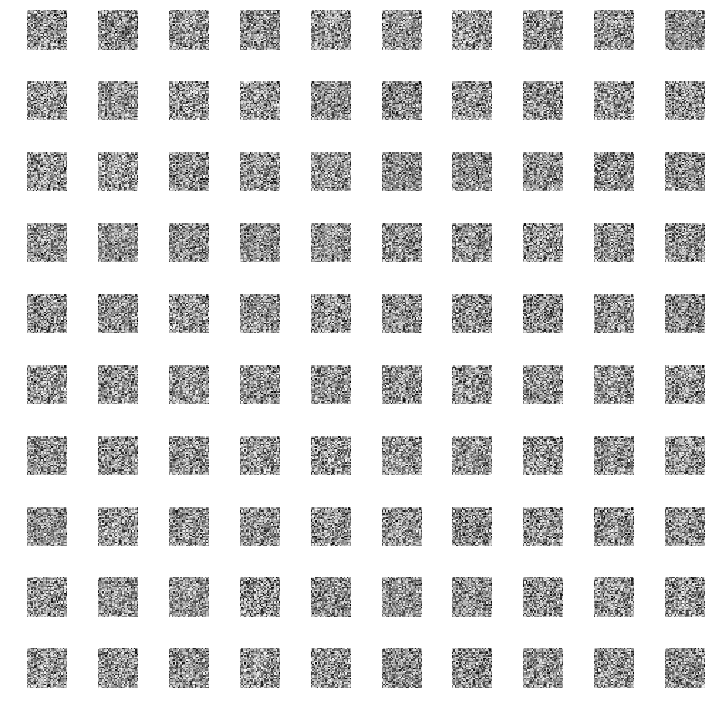

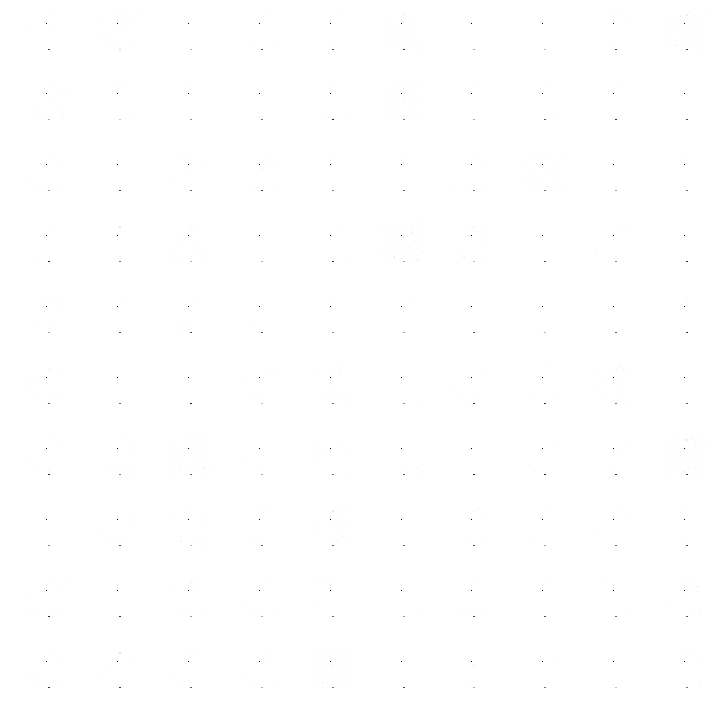

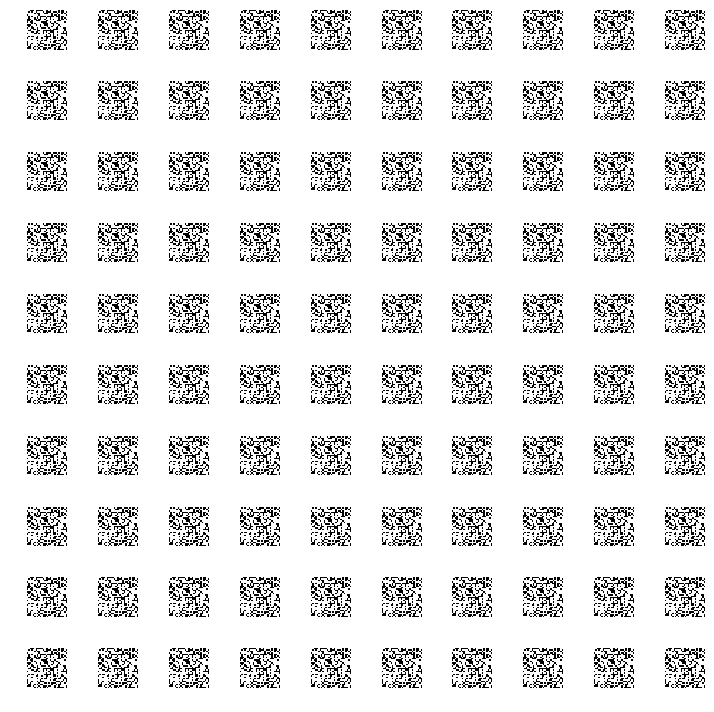

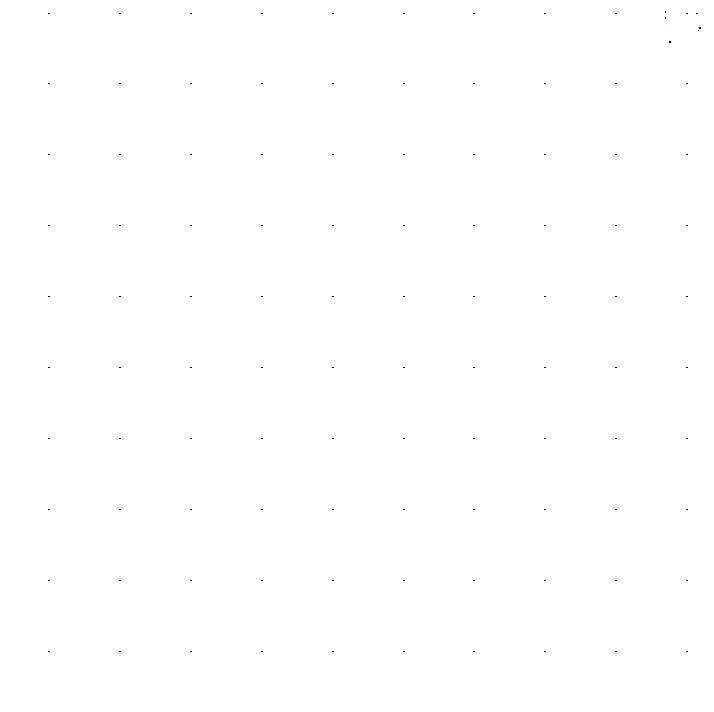

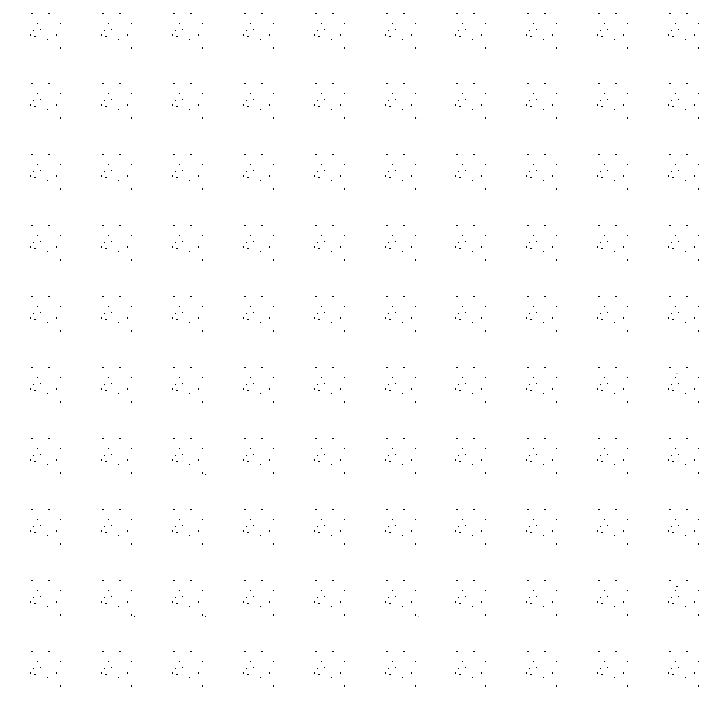

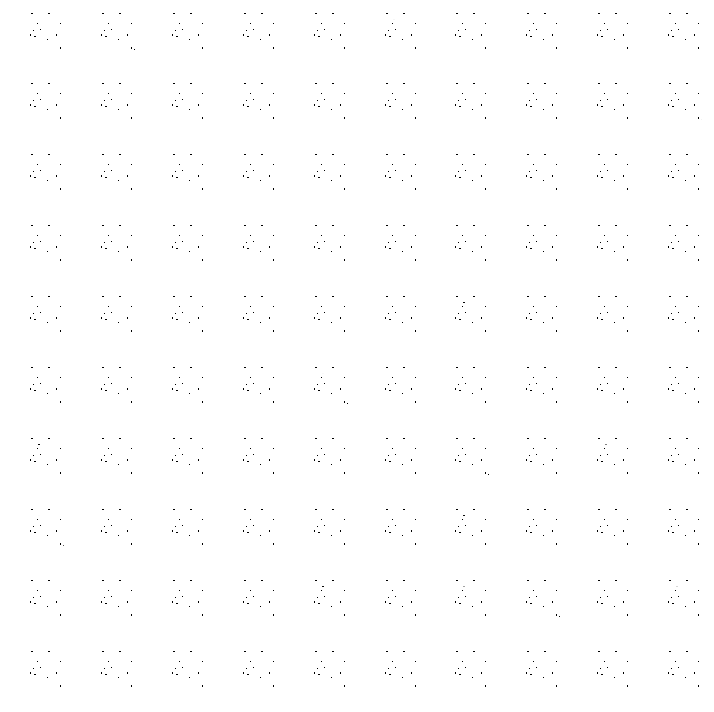

In [57]:
def train(epochs=1, batch_size=128):
    # Get the training emojis
    x_train = transform_emojis()
    batch_count = x_train.shape[0] // batch_size
    
    # build GAN network
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                size = batch_size)]
            # Generate fake emojis
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # one sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 1000 == 0:
            plot_generated_images(e, generator)

 
train(5000, 64)

# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji